In [64]:
!pip install shap
!pip install missingpy
!pip install miceforest

  Using cached shap-0.41.0-cp39-cp39-win_amd64.whl (435 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)


In [65]:
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

In [67]:
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from scipy import stats
from matplotlib import pylab
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_auc_score
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy import stats
from matplotlib import pylab
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB 
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier
#import shap
from missingpy import MissForest, KNNImputer
import miceforest as mf
import tensorflow as tf

In [31]:
def load_dataset(filename):
    dataset = pd.read_csv(filename)
    return dataset

In [32]:
def uniform_nan(dataset):
    dataset.replace("missing",np.NaN, inplace=True)
    dataset.replace("na",np.NaN,inplace=True)
    dataset.replace("#VALUE!",np.NaN,inplace=True)
    return dataset

In [33]:
def binary_encoder(dataset,feature,label_encoder_obj):
    for f in feature:
        dataset[f] = label_encoder_obj.fit_transform(dataset[f])
    return dataset

In [34]:
def null_counter_columns(dataset):
    counter = dataset.isna().sum()/len(dataset)
    return counter

In [35]:
def drop_rows(dataset,null_threshold):
    row_count = dataset.isnull().sum(axis=1)/len(dataset.columns) 
    dataset = dataset[dataset.isnull().sum(axis=1) < null_threshold*len(dataset.columns)]
    return dataset

In [36]:
def drop_columns(dataset,null_threshold):
    counter = null_counter_columns(dataset)
    cols_to_drop = counter[counter>null_threshold].keys()
    dataset = dataset.drop(cols_to_drop,axis=1)
    return dataset

In [37]:
def correlation_heatmap(dataset):
    fig, ax = plt.subplots(figsize=(40,40))
    sns.heatmap(dataset.corr(),annot=True,fmt='.1g',cmap='Spectral',ax=ax)
    plt.show()

In [38]:
def iterative_imputer(dataset):
    iter_impute = IterativeImputer(random_state=0)
    iter_impute.fit(dataset)
    imputed_dataset = iter_impute.transform(dataset)
    imputed_dataset = pd.DataFrame(data=imputed_dataset,columns=dataset.columns)
    return imputed_dataset

In [39]:
def dataset_split(dataset):
    X = dataset.iloc[:,:-1]
    y = dataset.iloc[:,-1:]
    X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7,random_state=1)
    return X,y,X_train, X_test, y_train, y_test

In [40]:
def SMOTE_Resampling(dataset):

    X = dataset.iloc[:,:-1]
    y = dataset.iloc[:,-1:]
    #y = y.to_numpy()
    print('Original dataset shape %s' % Counter(y))
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    print('Resampled dataset shape %s' % Counter(y_res))
    
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,train_size=0.5,random_state=1)
    return X,y,X_train, X_test, y_train, y_test

In [41]:
def normality(data,feature):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.kdeplot(data[feature])
    plt.subplot(1,2,2)
    stats.probplot(data[feature],plot=pylab)
    plt.show()

In [42]:
def class_counter(data):
    print("Class - 1: ",((data == 1).sum())/len(data))
    print("Class - 0: ",((data == 0).sum())/len(data))

## Models

In [43]:
def HistGradientBoostingClassification(X_train, X_test, y_train, y_test):

    clf = HistGradientBoostingClassifier()
    clf.fit(X_train, y_train.values.ravel())
    y_pred = clf.predict(X_test)
    print('Accuracy of classifier on train set: {:.2f}'.format(clf.score(X_train, y_train)))
    print('Accuracy of classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))
    from sklearn.metrics import confusion_matrix
    print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))
    from sklearn.metrics import classification_report
    print("Classification Report:\n",classification_report(y_test, y_pred))
    
    return clf

In [44]:
def xgb_classification(X_train, X_test, y_train, y_test):
    xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1, 
                               alpha = 2, n_estimators = 100)
    xg_reg.fit(X_train,y_train.values.ravel())
    preds = xg_reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print("RMSE: %f" % (rmse))
    
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_test, preds)
    print("Confusion Matrix:\n",confusion_matrix)
    from sklearn.metrics import classification_report
    print("Classification Report:\n",classification_report(y_test, preds))
    
    return xg_reg

In [45]:
def randomforest_classifier(X_train, X_test, y_train, y_test):

    rt=RandomForestClassifier(n_estimators=100,class_weight="balanced_subsample")
    rt.fit(X_train,y_train.values.ravel())
    y_pred=rt.predict(X_test)
    print("Recall:",recall_score(y_test, y_pred))
    roc_value = roc_auc_score(y_test, y_pred)
    print("ROC Value:",roc_value)
    
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n",confusion_matrix)
    from sklearn.metrics import classification_report
    print("Classification Report:\n",classification_report(y_test, y_pred))
    
    return rt

In [46]:
def LogisticRegression_Classifier(X_train, X_test, y_train, y_test):
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train.values.ravel())
    y_pred = logreg.predict(X_test)
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
    
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n",confusion_matrix)
    from sklearn.metrics import classification_report
    print("Classification Report:\n",classification_report(y_test, y_pred))
    
    return logreg

In [47]:
def svm_classifier(X_train, X_test, y_train, y_test):
    svclassifier = SVC(kernel='linear')
    svclassifier.fit(X_train, y_train.values.ravel())
    y_pred = svclassifier.predict(X_test)
    
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_test,y_pred)              
    print("Confusion Matrix:\n",confusion_matrix)
    from sklearn.metrics import classification_report
    print("Classification Report:\n",classification_report(y_test,y_pred))
    
    return svclassifier

In [48]:
def naive_bayes(X_train, X_test, y_train, y_test):

    gnb = BernoulliNB() 
    gnb.fit(X_train, y_train.values.ravel()) 
  
    #Applying and predicting 
    y_pred_nb = gnb.predict(X_test) 
    cv_scores = cross_val_score(gnb, X, y.values.ravel(),cv=10,scoring='precision')
    print("Cross-validation precision: %f" % cv_scores.mean())
    
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_test, y_pred_nb)
    print("Confusion Matrix:\n",confusion_matrix)
    from sklearn.metrics import classification_report
    print("Classification Report:\n",classification_report(y_test, y_pred_nb))
    
    return gnb

In [49]:
def CatBoost_classifier(X_train, X_test, y_train, y_test,weight):
    
    accuracy= []
    recall =[]
    roc_auc= []
    precision = []
    
    clf = CatBoostClassifier(verbose=True,random_state=0,scale_pos_weight=weight)
    clf.fit(X_train, y_train.values.ravel(),
            eval_set=(X_test,y_test.values.ravel()))
    y_pred = clf.predict(X_test)
    
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    recall.append(round(recall_score(y_test, y_pred),4))
    roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
    precision.append(round(precision_score(y_test, y_pred),4))

    model_names = ['Catboost_default']
    result_df1 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
    print(result_df1)
    
    from sklearn.metrics import confusion_matrix
    print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))
    from sklearn.metrics import classification_report
    print("Classification Report:\n",classification_report(y_test, y_pred))
    
    return clf

### TESTING

In [50]:
train_data = load_dataset("TrainingData.csv")

C:\Users\devan\AppData\Local\Temp/ipykernel_15480/2549988621.py:1: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  train_data = load_dataset("TrainingData.csv")


In [51]:
train_data.set_index('application_key',inplace=True)

In [52]:
train_data = uniform_nan(train_data)

In [53]:
label_encoder = LabelEncoder()
columns_to_encode = ['mvar47']
train_data = binary_encoder(train_data,columns_to_encode,label_encoder)

In [54]:
train_data = train_data.astype(float)

In [55]:
#drop rows
#train_data = drop_rows(train_data,0.5)

In [56]:
#drop columns
train_data= drop_columns(train_data,0.5)

In [57]:
train_data_copy = train_data.copy()

In [58]:
#missing data imputation
#train_data = iterative_imputer(train_data)

In [59]:
train_data.drop(['default_ind'],axis=1,inplace=True)

In [68]:

kernel = mf.ImputationKernel(data=train_data,
                        save_all_iterations=True,
                        random_state=2)
kernel.mice(3,verbose=True)

Initialized logger with name mice 1-3
Dataset 0
1  | mvar19 | mvar29 | mvar34 | mvar38 | mvar20 | mvar10 | mvar5 | mvar4 | mvar3 | mvar28 | mvar43 | mvar33 | mvar42 | mvar36 | mvar1 | mvar50 | mvar51 | mvar2 | mvar39 | mvar7 | mvar25 | mvar37 | mvar32 | mvar44 | mvar13 | mvar26 | mvar9 | mvar27 | mvar12 | mvar18 | mvar17 | mvar16 | mvar24 | mvar6 | mvar8 | mvar21 | mvar46 | mvar22 | mvar15 | mvar35 | mvar30
2  | mvar19 | mvar29 | mvar34 | mvar38 | mvar20 | mvar10 | mvar5 | mvar4 | mvar3 | mvar28 | mvar43 | mvar33 | mvar42 | mvar36 | mvar1 | mvar50 | mvar51 | mvar2 | mvar39 | mvar7 | mvar25 | mvar37 | mvar32 | mvar44 | mvar13 | mvar26 | mvar9 | mvar27 | mvar12 | mvar18 | mvar17 | mvar16 | mvar24 | mvar6 | mvar8 | mvar21 | mvar46 | mvar22 | mvar15 | mvar35 | mvar30
3  | mvar19 | mvar29 | mvar34 | mvar38 | mvar20 | mvar10 | mvar5 | mvar4 | mvar3 | mvar28 | mvar43 | mvar33 | mvar42 | mvar36 | mvar1 | mvar50 | mvar51 | mvar2 | mvar39 | mvar7 | mvar25 | mvar37 | mvar32 | mvar44 | mvar13 | mv

In [69]:
new_data_imputed = kernel.impute_new_data(train_data)
new_completed_data = new_data_imputed.complete_data(0)

In [70]:
#imputer = KNNImputer(n_neighbors=2,weights="uniform",row_max_missing=0.52)
#imputed_data = imputer.fit_transform(train_data)

In [71]:
new_completed_data = pd.DataFrame(data=new_completed_data,columns=train_data.columns,index=train_data.index)

In [72]:
pt = PowerTransformer()
testing=pt.fit_transform(new_completed_data)
testing = pd.DataFrame(data=testing,columns=new_completed_data.columns,index=train_data.index)

In [73]:
testing['default_ind'] = train_data_copy['default_ind'].copy()

#### NORMALISING ALL COLUMNS - TESTING

In [74]:
#dropping due to very low correlation across all columns
#imputed_data.drop(['application_key','mvar14','mvar48','mvar49'],axis=1,inplace=True)
#testing.drop(['application_key','mvar14','mvar48','mvar49'],axis=1,inplace=True)

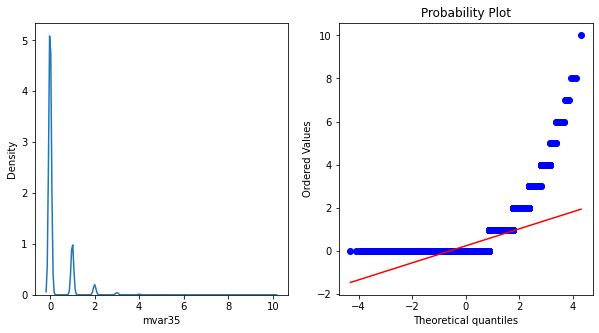

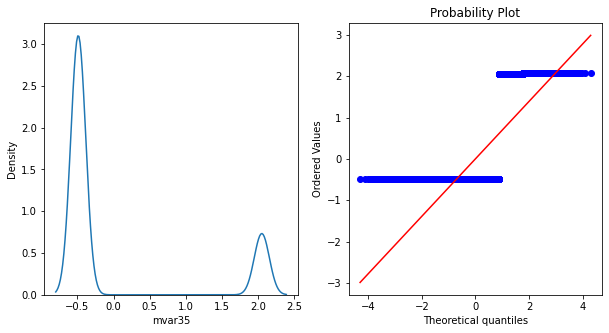

In [75]:
normality(new_completed_data,'mvar35')
normality(testing,'mvar35')

### PCA TESTING

In [76]:
pca_testing = pd.DataFrame(data=testing,columns=testing.columns,index=testing.index)
pca_testing.drop(['default_ind'],inplace=True,axis=1)

In [77]:
pca_testing.shape

(83000, 45)

In [78]:
#standard scaling
#from sklearn.preprocessing import MinMaxScaler

#scaling = MinMaxScaler()
#scaled_data = scaling.fit_transform(pca_testing)

In [79]:
from sklearn.decomposition import PCA

principal = PCA(n_components=0.95)
principal.fit(pca_testing)
pca_data = principal.transform(pca_testing)
print(pca_data.shape)

(83000, 29)


Text(0, 0.5, 'pc2')

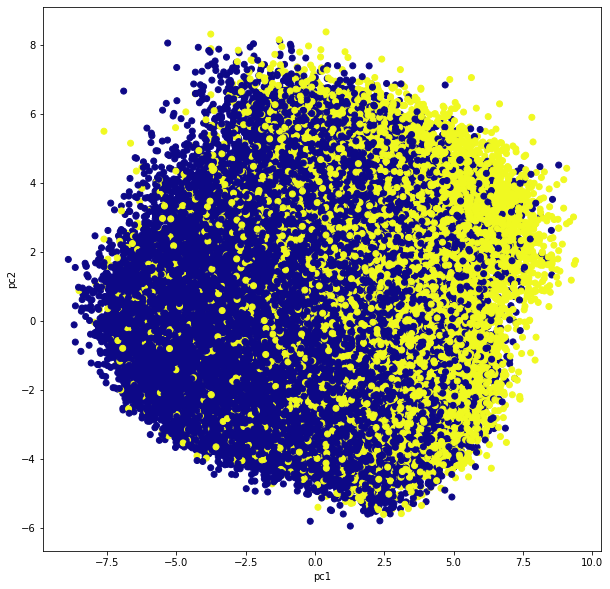

In [80]:
plt.figure(figsize=(10,10))
plt.scatter(pca_data[:,0],pca_data[:,1],c=testing['default_ind'],cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

In [81]:
print(principal.explained_variance_ratio_)

[0.24266189 0.13232666 0.08040016 0.04976037 0.04305279 0.03956577
 0.03170263 0.02798566 0.02657598 0.02370944 0.02273619 0.02181178
 0.01950879 0.01869446 0.01762548 0.0168323  0.01565683 0.01446395
 0.01400286 0.01371446 0.01220959 0.01162279 0.01088624 0.01011448
 0.00932579 0.00828682 0.00768591 0.00701881 0.00665   ]


In [82]:
"""
pca = PCA().fit(pca_data)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 44, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 44, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()
"""

'\npca = PCA().fit(pca_data)\n\nplt.rcParams["figure.figsize"] = (12,6)\n\nfig, ax = plt.subplots()\nxi = np.arange(1, 44, step=1)\ny = np.cumsum(pca.explained_variance_ratio_)\n\nplt.ylim(0.0,1.1)\nplt.plot(xi, y, marker=\'o\', linestyle=\'--\', color=\'b\')\n\nplt.xlabel(\'Number of Components\')\nplt.xticks(np.arange(0, 44, step=1)) #change from 0-based array index to 1-based human-readable label\nplt.ylabel(\'Cumulative variance (%)\')\nplt.title(\'The number of components needed to explain variance\')\n\nplt.axhline(y=0.95, color=\'r\', linestyle=\'-\')\nplt.text(0.5, 0.85, \'95% cut-off threshold\', color = \'red\', fontsize=16)\n\nax.grid(axis=\'x\')\nplt.show()\n'

In [83]:
pca_data = pd.DataFrame(pca_data,index=testing.index)
pca_data['default_ind'] = testing['default_ind'].copy()

In [84]:
testing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83000 entries, 230032 to 578068
Data columns (total 46 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   mvar1        83000 non-null  float64
 1   mvar2        83000 non-null  float64
 2   mvar3        83000 non-null  float64
 3   mvar4        83000 non-null  float64
 4   mvar5        83000 non-null  float64
 5   mvar6        83000 non-null  float64
 6   mvar7        83000 non-null  float64
 7   mvar8        83000 non-null  float64
 8   mvar9        83000 non-null  float64
 9   mvar10       83000 non-null  float64
 10  mvar12       83000 non-null  float64
 11  mvar13       83000 non-null  float64
 12  mvar14       83000 non-null  float64
 13  mvar15       83000 non-null  float64
 14  mvar16       83000 non-null  float64
 15  mvar17       83000 non-null  float64
 16  mvar18       83000 non-null  float64
 17  mvar19       83000 non-null  float64
 18  mvar20       83000 non-null  float64
 19

### MODEL TRAINING

In [85]:
X,y,X_train, X_test, y_train, y_test = dataset_split(testing)
model_nb = naive_bayes(X_train, X_test, y_train, y_test)

Cross-validation precision: 0.465395
Confusion Matrix:
 [[11965  5750]
 [ 2138  5048]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.68      0.75     17715
         1.0       0.47      0.70      0.56      7186

    accuracy                           0.68     24901
   macro avg       0.66      0.69      0.66     24901
weighted avg       0.74      0.68      0.70     24901



In [86]:
X,y,X_train, X_test, y_train, y_test = dataset_split(pca_data)
model_nb_pca = naive_bayes(X_train, X_test, y_train, y_test)

Cross-validation precision: 0.524922
Confusion Matrix:
 [[16036  1679]
 [ 5346  1840]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.91      0.82     17715
         1.0       0.52      0.26      0.34      7186

    accuracy                           0.72     24901
   macro avg       0.64      0.58      0.58     24901
weighted avg       0.68      0.72      0.68     24901



In [87]:
X,y,X_train, X_test, y_train, y_test = SMOTE_Resampling(pca_data)
model_nb_smote_pca = naive_bayes(X_train, X_test, y_train, y_test)

Original dataset shape Counter({'default_ind': 1})
Resampled dataset shape Counter({'default_ind': 1})
Cross-validation precision: 0.524922
Confusion Matrix:
 [[18394 11085]
 [ 7617 22049]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.62      0.66     29479
         1.0       0.67      0.74      0.70     29666

    accuracy                           0.68     59145
   macro avg       0.69      0.68      0.68     59145
weighted avg       0.69      0.68      0.68     59145



In [88]:
X,y,X_train, X_test, y_train, y_test = SMOTE_Resampling(testing)
model_nb_smote = naive_bayes(X_train, X_test, y_train, y_test)

Original dataset shape Counter({'default_ind': 1})
Resampled dataset shape Counter({'default_ind': 1})
Cross-validation precision: 0.465395
Confusion Matrix:
 [[18920 10559]
 [ 7915 21751]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.64      0.67     29479
         1.0       0.67      0.73      0.70     29666

    accuracy                           0.69     59145
   macro avg       0.69      0.69      0.69     59145
weighted avg       0.69      0.69      0.69     59145



In [89]:
X,y,X_train, X_test, y_train, y_test = dataset_split(testing)
model_hist = HistGradientBoostingClassification(X_train, X_test, y_train, y_test)

Accuracy of classifier on train set: 0.79
Accuracy of classifier on test set: 0.77
Confusion Matrix:
 [[16181  1534]
 [ 4235  2951]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.91      0.85     17715
         1.0       0.66      0.41      0.51      7186

    accuracy                           0.77     24901
   macro avg       0.73      0.66      0.68     24901
weighted avg       0.75      0.77      0.75     24901



In [90]:
X,y,X_train, X_test, y_train, y_test = SMOTE_Resampling(testing)
model_hist_smote = HistGradientBoostingClassification(X_train, X_test, y_train, y_test)

Original dataset shape Counter({'default_ind': 1})
Resampled dataset shape Counter({'default_ind': 1})
Accuracy of classifier on train set: 0.85
Accuracy of classifier on test set: 0.83
Confusion Matrix:
 [[26034  3445]
 [ 6869 22797]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.88      0.83     29479
         1.0       0.87      0.77      0.82     29666

    accuracy                           0.83     59145
   macro avg       0.83      0.83      0.83     59145
weighted avg       0.83      0.83      0.83     59145



In [91]:
X,y,X_train, X_test, y_train, y_test = dataset_split(pca_data)
model_hist_pca = HistGradientBoostingClassification(X_train, X_test, y_train, y_test)

Accuracy of classifier on train set: 0.79
Accuracy of classifier on test set: 0.76
Confusion Matrix:
 [[16144  1571]
 [ 4351  2835]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.91      0.85     17715
         1.0       0.64      0.39      0.49      7186

    accuracy                           0.76     24901
   macro avg       0.72      0.65      0.67     24901
weighted avg       0.75      0.76      0.74     24901



In [92]:
X,y,X_train, X_test, y_train, y_test = SMOTE_Resampling(pca_data)
model_hist_smote_pca = HistGradientBoostingClassification(X_train, X_test, y_train, y_test)

Original dataset shape Counter({'default_ind': 1})
Resampled dataset shape Counter({'default_ind': 1})
Accuracy of classifier on train set: 0.77
Accuracy of classifier on test set: 0.73
Confusion Matrix:
 [[21672  7807]
 [ 8057 21609]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.74      0.73     29479
         1.0       0.73      0.73      0.73     29666

    accuracy                           0.73     59145
   macro avg       0.73      0.73      0.73     59145
weighted avg       0.73      0.73      0.73     59145



In [93]:
X,y,X_train, X_test, y_train, y_test = dataset_split(testing)
model_cat_1 = CatBoost_classifier(X_train, X_test, y_train, y_test,1)

Learning rate set to 0.086429
0:	learn: 0.6607901	test: 0.6612412	best: 0.6612412 (0)	total: 244ms	remaining: 4m 4s
1:	learn: 0.6327849	test: 0.6333618	best: 0.6333618 (1)	total: 316ms	remaining: 2m 37s
2:	learn: 0.6099936	test: 0.6109506	best: 0.6109506 (2)	total: 398ms	remaining: 2m 12s
3:	learn: 0.5915545	test: 0.5929137	best: 0.5929137 (3)	total: 496ms	remaining: 2m 3s
4:	learn: 0.5766130	test: 0.5782662	best: 0.5782662 (4)	total: 573ms	remaining: 1m 54s
5:	learn: 0.5634468	test: 0.5652882	best: 0.5652882 (5)	total: 673ms	remaining: 1m 51s
6:	learn: 0.5530086	test: 0.5551033	best: 0.5551033 (6)	total: 777ms	remaining: 1m 50s
7:	learn: 0.5440962	test: 0.5464081	best: 0.5464081 (7)	total: 845ms	remaining: 1m 44s
8:	learn: 0.5368044	test: 0.5392253	best: 0.5392253 (8)	total: 938ms	remaining: 1m 43s
9:	learn: 0.5303090	test: 0.5329344	best: 0.5329344 (9)	total: 1.03s	remaining: 1m 42s
10:	learn: 0.5251163	test: 0.5280054	best: 0.5280054 (10)	total: 1.11s	remaining: 1m 39s
11:	learn: 0.

93:	learn: 0.4753017	test: 0.4890660	best: 0.4890541 (92)	total: 8.4s	remaining: 1m 20s
94:	learn: 0.4751114	test: 0.4889867	best: 0.4889867 (94)	total: 8.49s	remaining: 1m 20s
95:	learn: 0.4750028	test: 0.4889842	best: 0.4889842 (95)	total: 8.57s	remaining: 1m 20s
96:	learn: 0.4748256	test: 0.4889197	best: 0.4889197 (96)	total: 8.67s	remaining: 1m 20s
97:	learn: 0.4747047	test: 0.4888908	best: 0.4888908 (97)	total: 8.75s	remaining: 1m 20s
98:	learn: 0.4745357	test: 0.4888684	best: 0.4888684 (98)	total: 8.83s	remaining: 1m 20s
99:	learn: 0.4744226	test: 0.4888016	best: 0.4888016 (99)	total: 8.91s	remaining: 1m 20s
100:	learn: 0.4743066	test: 0.4887587	best: 0.4887587 (100)	total: 8.99s	remaining: 1m 20s
101:	learn: 0.4741802	test: 0.4887155	best: 0.4887155 (101)	total: 9.06s	remaining: 1m 19s
102:	learn: 0.4740628	test: 0.4886961	best: 0.4886961 (102)	total: 9.16s	remaining: 1m 19s
103:	learn: 0.4739288	test: 0.4886429	best: 0.4886429 (103)	total: 9.24s	remaining: 1m 19s
104:	learn: 0.

186:	learn: 0.4606805	test: 0.4869718	best: 0.4868901 (183)	total: 16.3s	remaining: 1m 10s
187:	learn: 0.4606150	test: 0.4869873	best: 0.4868901 (183)	total: 16.4s	remaining: 1m 10s
188:	learn: 0.4604614	test: 0.4868953	best: 0.4868901 (183)	total: 16.4s	remaining: 1m 10s
189:	learn: 0.4603094	test: 0.4868409	best: 0.4868409 (189)	total: 16.5s	remaining: 1m 10s
190:	learn: 0.4601984	test: 0.4868419	best: 0.4868409 (189)	total: 16.6s	remaining: 1m 10s
191:	learn: 0.4600270	test: 0.4867795	best: 0.4867795 (191)	total: 16.7s	remaining: 1m 10s
192:	learn: 0.4598720	test: 0.4867301	best: 0.4867301 (192)	total: 16.7s	remaining: 1m 10s
193:	learn: 0.4598087	test: 0.4867255	best: 0.4867255 (193)	total: 16.8s	remaining: 1m 9s
194:	learn: 0.4596175	test: 0.4866849	best: 0.4866849 (194)	total: 16.9s	remaining: 1m 9s
195:	learn: 0.4594663	test: 0.4866618	best: 0.4866618 (195)	total: 17s	remaining: 1m 9s
196:	learn: 0.4593701	test: 0.4866527	best: 0.4866527 (196)	total: 17.1s	remaining: 1m 9s
197:	

279:	learn: 0.4476763	test: 0.4864826	best: 0.4864826 (279)	total: 23.7s	remaining: 1m
280:	learn: 0.4475728	test: 0.4864657	best: 0.4864657 (280)	total: 23.8s	remaining: 1m
281:	learn: 0.4474199	test: 0.4864564	best: 0.4864564 (281)	total: 23.9s	remaining: 1m
282:	learn: 0.4472638	test: 0.4864289	best: 0.4864289 (282)	total: 24s	remaining: 1m
283:	learn: 0.4471385	test: 0.4864209	best: 0.4864209 (283)	total: 24s	remaining: 1m
284:	learn: 0.4470148	test: 0.4864149	best: 0.4864149 (284)	total: 24.1s	remaining: 1m
285:	learn: 0.4468787	test: 0.4864304	best: 0.4864149 (284)	total: 24.2s	remaining: 1m
286:	learn: 0.4467533	test: 0.4864413	best: 0.4864149 (284)	total: 24.3s	remaining: 1m
287:	learn: 0.4465796	test: 0.4864684	best: 0.4864149 (284)	total: 24.4s	remaining: 1m
288:	learn: 0.4463799	test: 0.4864811	best: 0.4864149 (284)	total: 24.4s	remaining: 1m
289:	learn: 0.4462932	test: 0.4864932	best: 0.4864149 (284)	total: 24.5s	remaining: 1m
290:	learn: 0.4461528	test: 0.4864494	best: 0.4

371:	learn: 0.4362590	test: 0.4864281	best: 0.4862537 (339)	total: 32.2s	remaining: 54.3s
372:	learn: 0.4362003	test: 0.4864203	best: 0.4862537 (339)	total: 32.3s	remaining: 54.3s
373:	learn: 0.4360950	test: 0.4864378	best: 0.4862537 (339)	total: 32.5s	remaining: 54.3s
374:	learn: 0.4359422	test: 0.4864355	best: 0.4862537 (339)	total: 32.6s	remaining: 54.4s
375:	learn: 0.4358442	test: 0.4864119	best: 0.4862537 (339)	total: 32.7s	remaining: 54.3s
376:	learn: 0.4356828	test: 0.4864197	best: 0.4862537 (339)	total: 32.9s	remaining: 54.3s
377:	learn: 0.4355463	test: 0.4864284	best: 0.4862537 (339)	total: 33s	remaining: 54.3s
378:	learn: 0.4354602	test: 0.4864467	best: 0.4862537 (339)	total: 33.1s	remaining: 54.2s
379:	learn: 0.4353656	test: 0.4864295	best: 0.4862537 (339)	total: 33.2s	remaining: 54.1s
380:	learn: 0.4352550	test: 0.4864666	best: 0.4862537 (339)	total: 33.3s	remaining: 54.1s
381:	learn: 0.4350988	test: 0.4864812	best: 0.4862537 (339)	total: 33.4s	remaining: 54.1s
382:	learn: 

463:	learn: 0.4254095	test: 0.4867502	best: 0.4862537 (339)	total: 42.2s	remaining: 48.7s
464:	learn: 0.4253314	test: 0.4867465	best: 0.4862537 (339)	total: 42.2s	remaining: 48.6s
465:	learn: 0.4251923	test: 0.4867286	best: 0.4862537 (339)	total: 42.3s	remaining: 48.5s
466:	learn: 0.4250464	test: 0.4867805	best: 0.4862537 (339)	total: 42.4s	remaining: 48.3s
467:	learn: 0.4250014	test: 0.4867824	best: 0.4862537 (339)	total: 42.4s	remaining: 48.2s
468:	learn: 0.4249206	test: 0.4867819	best: 0.4862537 (339)	total: 42.5s	remaining: 48.1s
469:	learn: 0.4247863	test: 0.4867869	best: 0.4862537 (339)	total: 42.6s	remaining: 48s
470:	learn: 0.4246496	test: 0.4867952	best: 0.4862537 (339)	total: 42.6s	remaining: 47.9s
471:	learn: 0.4245115	test: 0.4868373	best: 0.4862537 (339)	total: 42.7s	remaining: 47.8s
472:	learn: 0.4244368	test: 0.4868455	best: 0.4862537 (339)	total: 42.8s	remaining: 47.6s
473:	learn: 0.4243069	test: 0.4868367	best: 0.4862537 (339)	total: 42.8s	remaining: 47.5s
474:	learn: 

556:	learn: 0.4153961	test: 0.4875750	best: 0.4862537 (339)	total: 49.1s	remaining: 39s
557:	learn: 0.4152833	test: 0.4875670	best: 0.4862537 (339)	total: 49.2s	remaining: 38.9s
558:	learn: 0.4151775	test: 0.4875965	best: 0.4862537 (339)	total: 49.2s	remaining: 38.8s
559:	learn: 0.4151235	test: 0.4876031	best: 0.4862537 (339)	total: 49.3s	remaining: 38.7s
560:	learn: 0.4150399	test: 0.4876104	best: 0.4862537 (339)	total: 49.4s	remaining: 38.6s
561:	learn: 0.4149490	test: 0.4875949	best: 0.4862537 (339)	total: 49.4s	remaining: 38.5s
562:	learn: 0.4148310	test: 0.4876138	best: 0.4862537 (339)	total: 49.5s	remaining: 38.4s
563:	learn: 0.4147239	test: 0.4876501	best: 0.4862537 (339)	total: 49.6s	remaining: 38.3s
564:	learn: 0.4145878	test: 0.4876705	best: 0.4862537 (339)	total: 49.7s	remaining: 38.2s
565:	learn: 0.4145147	test: 0.4876785	best: 0.4862537 (339)	total: 49.8s	remaining: 38.1s
566:	learn: 0.4143949	test: 0.4876702	best: 0.4862537 (339)	total: 49.8s	remaining: 38.1s
567:	learn: 

648:	learn: 0.4055666	test: 0.4885917	best: 0.4862537 (339)	total: 56.8s	remaining: 30.7s
649:	learn: 0.4054404	test: 0.4886021	best: 0.4862537 (339)	total: 56.9s	remaining: 30.6s
650:	learn: 0.4053585	test: 0.4886087	best: 0.4862537 (339)	total: 57s	remaining: 30.5s
651:	learn: 0.4052634	test: 0.4886043	best: 0.4862537 (339)	total: 57.1s	remaining: 30.5s
652:	learn: 0.4051376	test: 0.4885902	best: 0.4862537 (339)	total: 57.2s	remaining: 30.4s
653:	learn: 0.4050170	test: 0.4885964	best: 0.4862537 (339)	total: 57.2s	remaining: 30.3s
654:	learn: 0.4048789	test: 0.4886214	best: 0.4862537 (339)	total: 57.3s	remaining: 30.2s
655:	learn: 0.4047539	test: 0.4886447	best: 0.4862537 (339)	total: 57.4s	remaining: 30.1s
656:	learn: 0.4046657	test: 0.4886510	best: 0.4862537 (339)	total: 57.5s	remaining: 30s
657:	learn: 0.4045472	test: 0.4886733	best: 0.4862537 (339)	total: 57.6s	remaining: 29.9s
658:	learn: 0.4044528	test: 0.4886969	best: 0.4862537 (339)	total: 57.7s	remaining: 29.8s
659:	learn: 0.

742:	learn: 0.3965054	test: 0.4894691	best: 0.4862537 (339)	total: 1m 4s	remaining: 22.3s
743:	learn: 0.3964479	test: 0.4894967	best: 0.4862537 (339)	total: 1m 4s	remaining: 22.2s
744:	learn: 0.3963236	test: 0.4894493	best: 0.4862537 (339)	total: 1m 4s	remaining: 22.1s
745:	learn: 0.3962141	test: 0.4894565	best: 0.4862537 (339)	total: 1m 4s	remaining: 22s
746:	learn: 0.3962048	test: 0.4894653	best: 0.4862537 (339)	total: 1m 4s	remaining: 21.9s
747:	learn: 0.3961160	test: 0.4894812	best: 0.4862537 (339)	total: 1m 4s	remaining: 21.9s
748:	learn: 0.3959935	test: 0.4894894	best: 0.4862537 (339)	total: 1m 4s	remaining: 21.8s
749:	learn: 0.3958957	test: 0.4894988	best: 0.4862537 (339)	total: 1m 5s	remaining: 21.7s
750:	learn: 0.3958675	test: 0.4895113	best: 0.4862537 (339)	total: 1m 5s	remaining: 21.6s
751:	learn: 0.3957819	test: 0.4895233	best: 0.4862537 (339)	total: 1m 5s	remaining: 21.5s
752:	learn: 0.3957194	test: 0.4895257	best: 0.4862537 (339)	total: 1m 5s	remaining: 21.4s
753:	learn: 

833:	learn: 0.3881021	test: 0.4904168	best: 0.4862537 (339)	total: 1m 12s	remaining: 14.4s
834:	learn: 0.3879817	test: 0.4904382	best: 0.4862537 (339)	total: 1m 12s	remaining: 14.3s
835:	learn: 0.3878485	test: 0.4904184	best: 0.4862537 (339)	total: 1m 12s	remaining: 14.2s
836:	learn: 0.3877597	test: 0.4903933	best: 0.4862537 (339)	total: 1m 12s	remaining: 14.1s
837:	learn: 0.3876164	test: 0.4904162	best: 0.4862537 (339)	total: 1m 12s	remaining: 14s
838:	learn: 0.3875468	test: 0.4904186	best: 0.4862537 (339)	total: 1m 12s	remaining: 14s
839:	learn: 0.3874702	test: 0.4904430	best: 0.4862537 (339)	total: 1m 12s	remaining: 13.9s
840:	learn: 0.3873862	test: 0.4904515	best: 0.4862537 (339)	total: 1m 12s	remaining: 13.8s
841:	learn: 0.3872857	test: 0.4904887	best: 0.4862537 (339)	total: 1m 13s	remaining: 13.7s
842:	learn: 0.3872165	test: 0.4904832	best: 0.4862537 (339)	total: 1m 13s	remaining: 13.6s
843:	learn: 0.3871162	test: 0.4904656	best: 0.4862537 (339)	total: 1m 13s	remaining: 13.5s
844

925:	learn: 0.3795093	test: 0.4911598	best: 0.4862537 (339)	total: 1m 21s	remaining: 6.54s
926:	learn: 0.3794252	test: 0.4911539	best: 0.4862537 (339)	total: 1m 21s	remaining: 6.45s
927:	learn: 0.3793172	test: 0.4911876	best: 0.4862537 (339)	total: 1m 22s	remaining: 6.36s
928:	learn: 0.3792331	test: 0.4912009	best: 0.4862537 (339)	total: 1m 22s	remaining: 6.27s
929:	learn: 0.3791814	test: 0.4912233	best: 0.4862537 (339)	total: 1m 22s	remaining: 6.19s
930:	learn: 0.3790582	test: 0.4911683	best: 0.4862537 (339)	total: 1m 22s	remaining: 6.1s
931:	learn: 0.3789653	test: 0.4911871	best: 0.4862537 (339)	total: 1m 22s	remaining: 6.01s
932:	learn: 0.3788465	test: 0.4911588	best: 0.4862537 (339)	total: 1m 22s	remaining: 5.92s
933:	learn: 0.3787197	test: 0.4911430	best: 0.4862537 (339)	total: 1m 22s	remaining: 5.83s
934:	learn: 0.3786371	test: 0.4911505	best: 0.4862537 (339)	total: 1m 22s	remaining: 5.74s
935:	learn: 0.3785536	test: 0.4911907	best: 0.4862537 (339)	total: 1m 22s	remaining: 5.65s


In [94]:
X,y,X_train, X_test, y_train, y_test = dataset_split(pca_data)
model_cat_pca_1 = CatBoost_classifier(X_train, X_test, y_train, y_test,1)

Learning rate set to 0.086429
0:	learn: 0.6608762	test: 0.6610259	best: 0.6610259 (0)	total: 70.4ms	remaining: 1m 10s
1:	learn: 0.6336648	test: 0.6340693	best: 0.6340693 (1)	total: 140ms	remaining: 1m 9s
2:	learn: 0.6118622	test: 0.6122493	best: 0.6122493 (2)	total: 219ms	remaining: 1m 12s
3:	learn: 0.5955856	test: 0.5961952	best: 0.5961952 (3)	total: 320ms	remaining: 1m 19s
4:	learn: 0.5812098	test: 0.5821255	best: 0.5821255 (4)	total: 390ms	remaining: 1m 17s
5:	learn: 0.5701921	test: 0.5712037	best: 0.5712037 (5)	total: 484ms	remaining: 1m 20s
6:	learn: 0.5603367	test: 0.5615412	best: 0.5615412 (6)	total: 559ms	remaining: 1m 19s
7:	learn: 0.5517351	test: 0.5530667	best: 0.5530667 (7)	total: 635ms	remaining: 1m 18s
8:	learn: 0.5443374	test: 0.5458260	best: 0.5458260 (8)	total: 709ms	remaining: 1m 18s
9:	learn: 0.5386880	test: 0.5403478	best: 0.5403478 (9)	total: 810ms	remaining: 1m 20s
10:	learn: 0.5336124	test: 0.5353869	best: 0.5353869 (10)	total: 874ms	remaining: 1m 18s
11:	learn: 

94:	learn: 0.4843517	test: 0.4968358	best: 0.4968358 (94)	total: 7.38s	remaining: 1m 10s
95:	learn: 0.4842092	test: 0.4967858	best: 0.4967858 (95)	total: 7.46s	remaining: 1m 10s
96:	learn: 0.4840317	test: 0.4967456	best: 0.4967456 (96)	total: 7.52s	remaining: 1m 10s
97:	learn: 0.4838653	test: 0.4966308	best: 0.4966308 (97)	total: 7.61s	remaining: 1m 10s
98:	learn: 0.4837389	test: 0.4966489	best: 0.4966308 (97)	total: 7.69s	remaining: 1m 9s
99:	learn: 0.4835818	test: 0.4966383	best: 0.4966308 (97)	total: 7.75s	remaining: 1m 9s
100:	learn: 0.4834692	test: 0.4965989	best: 0.4965989 (100)	total: 7.82s	remaining: 1m 9s
101:	learn: 0.4832976	test: 0.4965632	best: 0.4965632 (101)	total: 7.9s	remaining: 1m 9s
102:	learn: 0.4831575	test: 0.4965818	best: 0.4965632 (101)	total: 7.97s	remaining: 1m 9s
103:	learn: 0.4830041	test: 0.4965723	best: 0.4965632 (101)	total: 8.03s	remaining: 1m 9s
104:	learn: 0.4828130	test: 0.4965260	best: 0.4965260 (104)	total: 8.11s	remaining: 1m 9s
105:	learn: 0.48267

187:	learn: 0.4681117	test: 0.4947508	best: 0.4947263 (183)	total: 13.9s	remaining: 1m
188:	learn: 0.4679218	test: 0.4947776	best: 0.4947263 (183)	total: 14s	remaining: 1m
189:	learn: 0.4677338	test: 0.4947727	best: 0.4947263 (183)	total: 14.1s	remaining: 1m
190:	learn: 0.4675478	test: 0.4947369	best: 0.4947263 (183)	total: 14.2s	remaining: 1m
191:	learn: 0.4673636	test: 0.4947333	best: 0.4947263 (183)	total: 14.3s	remaining: 1m
192:	learn: 0.4671986	test: 0.4947194	best: 0.4947194 (192)	total: 14.4s	remaining: 1m
193:	learn: 0.4670232	test: 0.4947428	best: 0.4947194 (192)	total: 14.4s	remaining: 60s
194:	learn: 0.4668367	test: 0.4947479	best: 0.4947194 (192)	total: 14.5s	remaining: 59.9s
195:	learn: 0.4666317	test: 0.4947307	best: 0.4947194 (192)	total: 14.6s	remaining: 59.8s
196:	learn: 0.4664223	test: 0.4947273	best: 0.4947194 (192)	total: 14.6s	remaining: 59.7s
197:	learn: 0.4662627	test: 0.4947753	best: 0.4947194 (192)	total: 14.7s	remaining: 59.6s
198:	learn: 0.4661319	test: 0.49

281:	learn: 0.4524302	test: 0.4948616	best: 0.4945469 (231)	total: 20.7s	remaining: 52.8s
282:	learn: 0.4522950	test: 0.4948655	best: 0.4945469 (231)	total: 20.8s	remaining: 52.7s
283:	learn: 0.4521505	test: 0.4948817	best: 0.4945469 (231)	total: 20.9s	remaining: 52.6s
284:	learn: 0.4520000	test: 0.4948999	best: 0.4945469 (231)	total: 20.9s	remaining: 52.5s
285:	learn: 0.4518292	test: 0.4949067	best: 0.4945469 (231)	total: 21s	remaining: 52.5s
286:	learn: 0.4516766	test: 0.4948925	best: 0.4945469 (231)	total: 21.1s	remaining: 52.4s
287:	learn: 0.4515285	test: 0.4949229	best: 0.4945469 (231)	total: 21.2s	remaining: 52.3s
288:	learn: 0.4513812	test: 0.4949506	best: 0.4945469 (231)	total: 21.2s	remaining: 52.2s
289:	learn: 0.4512285	test: 0.4949141	best: 0.4945469 (231)	total: 21.3s	remaining: 52.2s
290:	learn: 0.4510581	test: 0.4949486	best: 0.4945469 (231)	total: 21.4s	remaining: 52.1s
291:	learn: 0.4508621	test: 0.4949602	best: 0.4945469 (231)	total: 21.5s	remaining: 52s
292:	learn: 0.

373:	learn: 0.4389697	test: 0.4953952	best: 0.4945469 (231)	total: 27.7s	remaining: 46.4s
374:	learn: 0.4388156	test: 0.4953819	best: 0.4945469 (231)	total: 27.8s	remaining: 46.4s
375:	learn: 0.4386715	test: 0.4954056	best: 0.4945469 (231)	total: 27.9s	remaining: 46.3s
376:	learn: 0.4385034	test: 0.4954142	best: 0.4945469 (231)	total: 28s	remaining: 46.2s
377:	learn: 0.4383748	test: 0.4954539	best: 0.4945469 (231)	total: 28s	remaining: 46.1s
378:	learn: 0.4382180	test: 0.4954723	best: 0.4945469 (231)	total: 28.1s	remaining: 46s
379:	learn: 0.4380622	test: 0.4954953	best: 0.4945469 (231)	total: 28.2s	remaining: 46s
380:	learn: 0.4378990	test: 0.4954491	best: 0.4945469 (231)	total: 28.3s	remaining: 45.9s
381:	learn: 0.4377339	test: 0.4954859	best: 0.4945469 (231)	total: 28.3s	remaining: 45.8s
382:	learn: 0.4375779	test: 0.4954284	best: 0.4945469 (231)	total: 28.4s	remaining: 45.8s
383:	learn: 0.4374379	test: 0.4953789	best: 0.4945469 (231)	total: 28.5s	remaining: 45.7s
384:	learn: 0.4373

467:	learn: 0.4257416	test: 0.4957023	best: 0.4945469 (231)	total: 35.2s	remaining: 40s
468:	learn: 0.4255800	test: 0.4957301	best: 0.4945469 (231)	total: 35.2s	remaining: 39.9s
469:	learn: 0.4254364	test: 0.4957095	best: 0.4945469 (231)	total: 35.3s	remaining: 39.8s
470:	learn: 0.4252873	test: 0.4957329	best: 0.4945469 (231)	total: 35.4s	remaining: 39.7s
471:	learn: 0.4251667	test: 0.4957739	best: 0.4945469 (231)	total: 35.5s	remaining: 39.7s
472:	learn: 0.4250436	test: 0.4957939	best: 0.4945469 (231)	total: 35.5s	remaining: 39.6s
473:	learn: 0.4249198	test: 0.4957847	best: 0.4945469 (231)	total: 35.6s	remaining: 39.5s
474:	learn: 0.4248210	test: 0.4957589	best: 0.4945469 (231)	total: 35.7s	remaining: 39.5s
475:	learn: 0.4247008	test: 0.4958268	best: 0.4945469 (231)	total: 35.8s	remaining: 39.4s
476:	learn: 0.4245976	test: 0.4958053	best: 0.4945469 (231)	total: 35.8s	remaining: 39.3s
477:	learn: 0.4244939	test: 0.4958231	best: 0.4945469 (231)	total: 35.9s	remaining: 39.2s
478:	learn: 

561:	learn: 0.4136528	test: 0.4965206	best: 0.4945469 (231)	total: 42.3s	remaining: 33s
562:	learn: 0.4134892	test: 0.4964694	best: 0.4945469 (231)	total: 42.4s	remaining: 32.9s
563:	learn: 0.4133662	test: 0.4964755	best: 0.4945469 (231)	total: 42.5s	remaining: 32.9s
564:	learn: 0.4132352	test: 0.4964899	best: 0.4945469 (231)	total: 42.6s	remaining: 32.8s
565:	learn: 0.4131110	test: 0.4964756	best: 0.4945469 (231)	total: 42.6s	remaining: 32.7s
566:	learn: 0.4129889	test: 0.4964318	best: 0.4945469 (231)	total: 42.7s	remaining: 32.6s
567:	learn: 0.4128392	test: 0.4964231	best: 0.4945469 (231)	total: 42.8s	remaining: 32.6s
568:	learn: 0.4127151	test: 0.4964027	best: 0.4945469 (231)	total: 42.9s	remaining: 32.5s
569:	learn: 0.4126072	test: 0.4964184	best: 0.4945469 (231)	total: 42.9s	remaining: 32.4s
570:	learn: 0.4124864	test: 0.4964031	best: 0.4945469 (231)	total: 43s	remaining: 32.3s
571:	learn: 0.4123802	test: 0.4963888	best: 0.4945469 (231)	total: 43.1s	remaining: 32.2s
572:	learn: 0.

655:	learn: 0.4020593	test: 0.4971966	best: 0.4945469 (231)	total: 49.4s	remaining: 25.9s
656:	learn: 0.4019196	test: 0.4972501	best: 0.4945469 (231)	total: 49.5s	remaining: 25.8s
657:	learn: 0.4018114	test: 0.4972787	best: 0.4945469 (231)	total: 49.6s	remaining: 25.8s
658:	learn: 0.4017068	test: 0.4973052	best: 0.4945469 (231)	total: 49.7s	remaining: 25.7s
659:	learn: 0.4016006	test: 0.4973306	best: 0.4945469 (231)	total: 49.7s	remaining: 25.6s
660:	learn: 0.4014857	test: 0.4973187	best: 0.4945469 (231)	total: 49.8s	remaining: 25.5s
661:	learn: 0.4014079	test: 0.4973502	best: 0.4945469 (231)	total: 49.9s	remaining: 25.5s
662:	learn: 0.4013200	test: 0.4973589	best: 0.4945469 (231)	total: 49.9s	remaining: 25.4s
663:	learn: 0.4012152	test: 0.4973782	best: 0.4945469 (231)	total: 50s	remaining: 25.3s
664:	learn: 0.4011021	test: 0.4973416	best: 0.4945469 (231)	total: 50.1s	remaining: 25.2s
665:	learn: 0.4010148	test: 0.4973808	best: 0.4945469 (231)	total: 50.2s	remaining: 25.2s
666:	learn: 

749:	learn: 0.3913889	test: 0.4983772	best: 0.4945469 (231)	total: 56.5s	remaining: 18.8s
750:	learn: 0.3912879	test: 0.4983724	best: 0.4945469 (231)	total: 56.6s	remaining: 18.8s
751:	learn: 0.3911976	test: 0.4983628	best: 0.4945469 (231)	total: 56.6s	remaining: 18.7s
752:	learn: 0.3910781	test: 0.4983827	best: 0.4945469 (231)	total: 56.7s	remaining: 18.6s
753:	learn: 0.3909642	test: 0.4983842	best: 0.4945469 (231)	total: 56.8s	remaining: 18.5s
754:	learn: 0.3908629	test: 0.4984052	best: 0.4945469 (231)	total: 56.9s	remaining: 18.5s
755:	learn: 0.3907691	test: 0.4984389	best: 0.4945469 (231)	total: 57s	remaining: 18.4s
756:	learn: 0.3906298	test: 0.4983919	best: 0.4945469 (231)	total: 57.1s	remaining: 18.3s
757:	learn: 0.3905177	test: 0.4983733	best: 0.4945469 (231)	total: 57.2s	remaining: 18.2s
758:	learn: 0.3904123	test: 0.4983832	best: 0.4945469 (231)	total: 57.2s	remaining: 18.2s
759:	learn: 0.3903053	test: 0.4983850	best: 0.4945469 (231)	total: 57.3s	remaining: 18.1s
760:	learn: 

841:	learn: 0.3810429	test: 0.4994106	best: 0.4945469 (231)	total: 1m 3s	remaining: 12s
842:	learn: 0.3809446	test: 0.4994509	best: 0.4945469 (231)	total: 1m 3s	remaining: 11.9s
843:	learn: 0.3808174	test: 0.4994768	best: 0.4945469 (231)	total: 1m 3s	remaining: 11.8s
844:	learn: 0.3807279	test: 0.4994497	best: 0.4945469 (231)	total: 1m 3s	remaining: 11.7s
845:	learn: 0.3805992	test: 0.4994454	best: 0.4945469 (231)	total: 1m 4s	remaining: 11.7s
846:	learn: 0.3804828	test: 0.4994885	best: 0.4945469 (231)	total: 1m 4s	remaining: 11.6s
847:	learn: 0.3804002	test: 0.4994632	best: 0.4945469 (231)	total: 1m 4s	remaining: 11.5s
848:	learn: 0.3802836	test: 0.4994792	best: 0.4945469 (231)	total: 1m 4s	remaining: 11.4s
849:	learn: 0.3801654	test: 0.4994757	best: 0.4945469 (231)	total: 1m 4s	remaining: 11.4s
850:	learn: 0.3800432	test: 0.4995249	best: 0.4945469 (231)	total: 1m 4s	remaining: 11.3s
851:	learn: 0.3799271	test: 0.4995160	best: 0.4945469 (231)	total: 1m 4s	remaining: 11.2s
852:	learn: 

932:	learn: 0.3716147	test: 0.5002350	best: 0.4945469 (231)	total: 1m 12s	remaining: 5.22s
933:	learn: 0.3714899	test: 0.5002487	best: 0.4945469 (231)	total: 1m 12s	remaining: 5.14s
934:	learn: 0.3713675	test: 0.5002326	best: 0.4945469 (231)	total: 1m 12s	remaining: 5.07s
935:	learn: 0.3712454	test: 0.5002448	best: 0.4945469 (231)	total: 1m 12s	remaining: 4.99s
936:	learn: 0.3711311	test: 0.5002605	best: 0.4945469 (231)	total: 1m 13s	remaining: 4.91s
937:	learn: 0.3710116	test: 0.5002801	best: 0.4945469 (231)	total: 1m 13s	remaining: 4.83s
938:	learn: 0.3709125	test: 0.5003093	best: 0.4945469 (231)	total: 1m 13s	remaining: 4.76s
939:	learn: 0.3708133	test: 0.5003577	best: 0.4945469 (231)	total: 1m 13s	remaining: 4.68s
940:	learn: 0.3707262	test: 0.5004045	best: 0.4945469 (231)	total: 1m 13s	remaining: 4.6s
941:	learn: 0.3706179	test: 0.5004396	best: 0.4945469 (231)	total: 1m 13s	remaining: 4.52s
942:	learn: 0.3705251	test: 0.5004447	best: 0.4945469 (231)	total: 1m 13s	remaining: 4.45s


In [95]:
X,y,X_train, X_test, y_train, y_test = dataset_split(testing)
model_cat_3 = CatBoost_classifier(X_train, X_test, y_train, y_test,3)

Learning rate set to 0.086429
0:	learn: 0.6740480	test: 0.6742259	best: 0.6742259 (0)	total: 99ms	remaining: 1m 38s
1:	learn: 0.6592933	test: 0.6597690	best: 0.6597690 (1)	total: 188ms	remaining: 1m 33s
2:	learn: 0.6471863	test: 0.6477867	best: 0.6477867 (2)	total: 289ms	remaining: 1m 36s
3:	learn: 0.6369105	test: 0.6375812	best: 0.6375812 (3)	total: 372ms	remaining: 1m 32s
4:	learn: 0.6272520	test: 0.6280528	best: 0.6280528 (4)	total: 471ms	remaining: 1m 33s
5:	learn: 0.6190222	test: 0.6199394	best: 0.6199394 (5)	total: 536ms	remaining: 1m 28s
6:	learn: 0.6116167	test: 0.6126210	best: 0.6126210 (6)	total: 588ms	remaining: 1m 23s
7:	learn: 0.6057588	test: 0.6068829	best: 0.6068829 (7)	total: 640ms	remaining: 1m 19s
8:	learn: 0.6010795	test: 0.6023539	best: 0.6023539 (8)	total: 737ms	remaining: 1m 21s
9:	learn: 0.5965543	test: 0.5978676	best: 0.5978676 (9)	total: 830ms	remaining: 1m 22s
10:	learn: 0.5930704	test: 0.5946135	best: 0.5946135 (10)	total: 909ms	remaining: 1m 21s
11:	learn: 0

94:	learn: 0.5457328	test: 0.5577866	best: 0.5577755 (93)	total: 7.86s	remaining: 1m 14s
95:	learn: 0.5455334	test: 0.5577352	best: 0.5577352 (95)	total: 7.95s	remaining: 1m 14s
96:	learn: 0.5453921	test: 0.5577259	best: 0.5577259 (96)	total: 8.03s	remaining: 1m 14s
97:	learn: 0.5452266	test: 0.5576618	best: 0.5576618 (97)	total: 8.12s	remaining: 1m 14s
98:	learn: 0.5450006	test: 0.5575366	best: 0.5575366 (98)	total: 8.2s	remaining: 1m 14s
99:	learn: 0.5447483	test: 0.5574348	best: 0.5574348 (99)	total: 8.28s	remaining: 1m 14s
100:	learn: 0.5445913	test: 0.5573908	best: 0.5573908 (100)	total: 8.37s	remaining: 1m 14s
101:	learn: 0.5444118	test: 0.5573318	best: 0.5573318 (101)	total: 8.46s	remaining: 1m 14s
102:	learn: 0.5442684	test: 0.5572575	best: 0.5572575 (102)	total: 8.52s	remaining: 1m 14s
103:	learn: 0.5441674	test: 0.5572658	best: 0.5572575 (102)	total: 8.58s	remaining: 1m 13s
104:	learn: 0.5439906	test: 0.5572155	best: 0.5572155 (104)	total: 8.67s	remaining: 1m 13s
105:	learn: 

185:	learn: 0.5283096	test: 0.5544477	best: 0.5544138 (184)	total: 14.9s	remaining: 1m 5s
186:	learn: 0.5280947	test: 0.5544784	best: 0.5544138 (184)	total: 15s	remaining: 1m 5s
187:	learn: 0.5278707	test: 0.5545046	best: 0.5544138 (184)	total: 15.1s	remaining: 1m 5s
188:	learn: 0.5276403	test: 0.5545194	best: 0.5544138 (184)	total: 15.1s	remaining: 1m 4s
189:	learn: 0.5274648	test: 0.5545168	best: 0.5544138 (184)	total: 15.2s	remaining: 1m 4s
190:	learn: 0.5272506	test: 0.5545450	best: 0.5544138 (184)	total: 15.3s	remaining: 1m 4s
191:	learn: 0.5270276	test: 0.5545222	best: 0.5544138 (184)	total: 15.4s	remaining: 1m 4s
192:	learn: 0.5268155	test: 0.5544619	best: 0.5544138 (184)	total: 15.5s	remaining: 1m 4s
193:	learn: 0.5266540	test: 0.5544408	best: 0.5544138 (184)	total: 15.5s	remaining: 1m 4s
194:	learn: 0.5265009	test: 0.5544808	best: 0.5544138 (184)	total: 15.6s	remaining: 1m 4s
195:	learn: 0.5263038	test: 0.5544863	best: 0.5544138 (184)	total: 15.7s	remaining: 1m 4s
196:	learn: 

280:	learn: 0.5117037	test: 0.5544824	best: 0.5540414 (237)	total: 22.6s	remaining: 57.8s
281:	learn: 0.5115224	test: 0.5544532	best: 0.5540414 (237)	total: 22.6s	remaining: 57.7s
282:	learn: 0.5112797	test: 0.5544556	best: 0.5540414 (237)	total: 22.7s	remaining: 57.5s
283:	learn: 0.5110698	test: 0.5545264	best: 0.5540414 (237)	total: 22.8s	remaining: 57.4s
284:	learn: 0.5108845	test: 0.5545790	best: 0.5540414 (237)	total: 22.8s	remaining: 57.2s
285:	learn: 0.5106821	test: 0.5545776	best: 0.5540414 (237)	total: 22.9s	remaining: 57.2s
286:	learn: 0.5105712	test: 0.5545955	best: 0.5540414 (237)	total: 23s	remaining: 57.1s
287:	learn: 0.5104301	test: 0.5546182	best: 0.5540414 (237)	total: 23.1s	remaining: 57s
288:	learn: 0.5102921	test: 0.5546478	best: 0.5540414 (237)	total: 23.1s	remaining: 56.9s
289:	learn: 0.5102125	test: 0.5546663	best: 0.5540414 (237)	total: 23.2s	remaining: 56.8s
290:	learn: 0.5100379	test: 0.5546670	best: 0.5540414 (237)	total: 23.3s	remaining: 56.8s
291:	learn: 0.

373:	learn: 0.4967726	test: 0.5554615	best: 0.5540414 (237)	total: 30.4s	remaining: 50.9s
374:	learn: 0.4966009	test: 0.5554618	best: 0.5540414 (237)	total: 30.5s	remaining: 50.8s
375:	learn: 0.4965970	test: 0.5554726	best: 0.5540414 (237)	total: 30.5s	remaining: 50.7s
376:	learn: 0.4964356	test: 0.5554712	best: 0.5540414 (237)	total: 30.6s	remaining: 50.6s
377:	learn: 0.4962915	test: 0.5555532	best: 0.5540414 (237)	total: 30.7s	remaining: 50.5s
378:	learn: 0.4960677	test: 0.5556402	best: 0.5540414 (237)	total: 30.8s	remaining: 50.4s
379:	learn: 0.4959027	test: 0.5556240	best: 0.5540414 (237)	total: 30.8s	remaining: 50.3s
380:	learn: 0.4958125	test: 0.5556608	best: 0.5540414 (237)	total: 31s	remaining: 50.3s
381:	learn: 0.4956954	test: 0.5556447	best: 0.5540414 (237)	total: 31s	remaining: 50.2s
382:	learn: 0.4956903	test: 0.5556498	best: 0.5540414 (237)	total: 31.1s	remaining: 50.1s
383:	learn: 0.4955663	test: 0.5556191	best: 0.5540414 (237)	total: 31.2s	remaining: 50s
384:	learn: 0.49

466:	learn: 0.4838578	test: 0.5569789	best: 0.5540414 (237)	total: 37.5s	remaining: 42.8s
467:	learn: 0.4836983	test: 0.5570025	best: 0.5540414 (237)	total: 37.6s	remaining: 42.7s
468:	learn: 0.4835399	test: 0.5570069	best: 0.5540414 (237)	total: 37.6s	remaining: 42.6s
469:	learn: 0.4834089	test: 0.5570416	best: 0.5540414 (237)	total: 37.7s	remaining: 42.5s
470:	learn: 0.4833405	test: 0.5570401	best: 0.5540414 (237)	total: 37.8s	remaining: 42.4s
471:	learn: 0.4832355	test: 0.5570599	best: 0.5540414 (237)	total: 37.8s	remaining: 42.3s
472:	learn: 0.4831049	test: 0.5570527	best: 0.5540414 (237)	total: 37.9s	remaining: 42.2s
473:	learn: 0.4829215	test: 0.5571100	best: 0.5540414 (237)	total: 38s	remaining: 42.1s
474:	learn: 0.4827934	test: 0.5571296	best: 0.5540414 (237)	total: 38.1s	remaining: 42.1s
475:	learn: 0.4826513	test: 0.5571090	best: 0.5540414 (237)	total: 38.1s	remaining: 42s
476:	learn: 0.4825856	test: 0.5570889	best: 0.5540414 (237)	total: 38.2s	remaining: 41.9s
477:	learn: 0.

560:	learn: 0.4707466	test: 0.5583644	best: 0.5540414 (237)	total: 43.8s	remaining: 34.3s
561:	learn: 0.4705671	test: 0.5584474	best: 0.5540414 (237)	total: 43.9s	remaining: 34.2s
562:	learn: 0.4703647	test: 0.5584710	best: 0.5540414 (237)	total: 43.9s	remaining: 34.1s
563:	learn: 0.4702558	test: 0.5584411	best: 0.5540414 (237)	total: 44s	remaining: 34s
564:	learn: 0.4701118	test: 0.5584474	best: 0.5540414 (237)	total: 44.1s	remaining: 34s
565:	learn: 0.4699149	test: 0.5584418	best: 0.5540414 (237)	total: 44.2s	remaining: 33.9s
566:	learn: 0.4697599	test: 0.5584416	best: 0.5540414 (237)	total: 44.3s	remaining: 33.8s
567:	learn: 0.4696164	test: 0.5584563	best: 0.5540414 (237)	total: 44.3s	remaining: 33.7s
568:	learn: 0.4694914	test: 0.5584782	best: 0.5540414 (237)	total: 44.4s	remaining: 33.6s
569:	learn: 0.4693651	test: 0.5584632	best: 0.5540414 (237)	total: 44.5s	remaining: 33.5s
570:	learn: 0.4692374	test: 0.5584872	best: 0.5540414 (237)	total: 44.6s	remaining: 33.5s
571:	learn: 0.46

653:	learn: 0.4581052	test: 0.5592538	best: 0.5540414 (237)	total: 50.5s	remaining: 26.7s
654:	learn: 0.4579488	test: 0.5592924	best: 0.5540414 (237)	total: 50.5s	remaining: 26.6s
655:	learn: 0.4578038	test: 0.5593045	best: 0.5540414 (237)	total: 50.6s	remaining: 26.5s
656:	learn: 0.4576805	test: 0.5593334	best: 0.5540414 (237)	total: 50.7s	remaining: 26.4s
657:	learn: 0.4575470	test: 0.5593319	best: 0.5540414 (237)	total: 50.7s	remaining: 26.4s
658:	learn: 0.4574162	test: 0.5593711	best: 0.5540414 (237)	total: 50.8s	remaining: 26.3s
659:	learn: 0.4572793	test: 0.5593982	best: 0.5540414 (237)	total: 50.9s	remaining: 26.2s
660:	learn: 0.4571958	test: 0.5594210	best: 0.5540414 (237)	total: 50.9s	remaining: 26.1s
661:	learn: 0.4570221	test: 0.5594607	best: 0.5540414 (237)	total: 51s	remaining: 26s
662:	learn: 0.4568223	test: 0.5594810	best: 0.5540414 (237)	total: 51.1s	remaining: 26s
663:	learn: 0.4566943	test: 0.5594944	best: 0.5540414 (237)	total: 51.1s	remaining: 25.9s
664:	learn: 0.45

746:	learn: 0.4464164	test: 0.5608593	best: 0.5540414 (237)	total: 56.6s	remaining: 19.2s
747:	learn: 0.4462929	test: 0.5608981	best: 0.5540414 (237)	total: 56.7s	remaining: 19.1s
748:	learn: 0.4462380	test: 0.5608954	best: 0.5540414 (237)	total: 56.7s	remaining: 19s
749:	learn: 0.4461290	test: 0.5609292	best: 0.5540414 (237)	total: 56.8s	remaining: 18.9s
750:	learn: 0.4460061	test: 0.5609209	best: 0.5540414 (237)	total: 56.9s	remaining: 18.9s
751:	learn: 0.4458874	test: 0.5608909	best: 0.5540414 (237)	total: 57s	remaining: 18.8s
752:	learn: 0.4457193	test: 0.5608986	best: 0.5540414 (237)	total: 57s	remaining: 18.7s
753:	learn: 0.4455679	test: 0.5609332	best: 0.5540414 (237)	total: 57.1s	remaining: 18.6s
754:	learn: 0.4454247	test: 0.5609370	best: 0.5540414 (237)	total: 57.2s	remaining: 18.6s
755:	learn: 0.4452977	test: 0.5609556	best: 0.5540414 (237)	total: 57.2s	remaining: 18.5s
756:	learn: 0.4451501	test: 0.5609943	best: 0.5540414 (237)	total: 57.3s	remaining: 18.4s
757:	learn: 0.44

838:	learn: 0.4357706	test: 0.5624384	best: 0.5540414 (237)	total: 1m 3s	remaining: 12.1s
839:	learn: 0.4356317	test: 0.5624359	best: 0.5540414 (237)	total: 1m 3s	remaining: 12s
840:	learn: 0.4355243	test: 0.5624690	best: 0.5540414 (237)	total: 1m 3s	remaining: 11.9s
841:	learn: 0.4354055	test: 0.5624909	best: 0.5540414 (237)	total: 1m 3s	remaining: 11.9s
842:	learn: 0.4352337	test: 0.5624842	best: 0.5540414 (237)	total: 1m 3s	remaining: 11.8s
843:	learn: 0.4351563	test: 0.5624368	best: 0.5540414 (237)	total: 1m 3s	remaining: 11.7s
844:	learn: 0.4350743	test: 0.5624564	best: 0.5540414 (237)	total: 1m 3s	remaining: 11.6s
845:	learn: 0.4349550	test: 0.5625601	best: 0.5540414 (237)	total: 1m 3s	remaining: 11.6s
846:	learn: 0.4348248	test: 0.5625555	best: 0.5540414 (237)	total: 1m 3s	remaining: 11.5s
847:	learn: 0.4347282	test: 0.5625534	best: 0.5540414 (237)	total: 1m 3s	remaining: 11.4s
848:	learn: 0.4346111	test: 0.5625761	best: 0.5540414 (237)	total: 1m 3s	remaining: 11.3s
849:	learn: 

931:	learn: 0.4256165	test: 0.5638791	best: 0.5540414 (237)	total: 1m 11s	remaining: 5.21s
932:	learn: 0.4254775	test: 0.5639004	best: 0.5540414 (237)	total: 1m 11s	remaining: 5.14s
933:	learn: 0.4253719	test: 0.5639306	best: 0.5540414 (237)	total: 1m 11s	remaining: 5.06s
934:	learn: 0.4252508	test: 0.5639453	best: 0.5540414 (237)	total: 1m 11s	remaining: 4.98s
935:	learn: 0.4251649	test: 0.5639350	best: 0.5540414 (237)	total: 1m 11s	remaining: 4.9s
936:	learn: 0.4250545	test: 0.5639222	best: 0.5540414 (237)	total: 1m 11s	remaining: 4.83s
937:	learn: 0.4249488	test: 0.5639471	best: 0.5540414 (237)	total: 1m 11s	remaining: 4.75s
938:	learn: 0.4248428	test: 0.5638999	best: 0.5540414 (237)	total: 1m 11s	remaining: 4.67s
939:	learn: 0.4247288	test: 0.5638987	best: 0.5540414 (237)	total: 1m 11s	remaining: 4.59s
940:	learn: 0.4246139	test: 0.5638860	best: 0.5540414 (237)	total: 1m 12s	remaining: 4.52s
941:	learn: 0.4245323	test: 0.5639286	best: 0.5540414 (237)	total: 1m 12s	remaining: 4.44s


In [96]:
X,y,X_train, X_test, y_train, y_test = dataset_split(pca_data)
model_cat_pca_3 = CatBoost_classifier(X_train, X_test, y_train, y_test,3)

Learning rate set to 0.086429
0:	learn: 0.6753827	test: 0.6752301	best: 0.6752301 (0)	total: 55.8ms	remaining: 55.8s
1:	learn: 0.6609238	test: 0.6606997	best: 0.6606997 (1)	total: 107ms	remaining: 53.3s
2:	learn: 0.6489088	test: 0.6488327	best: 0.6488327 (2)	total: 164ms	remaining: 54.5s
3:	learn: 0.6386844	test: 0.6385717	best: 0.6385717 (3)	total: 231ms	remaining: 57.5s
4:	learn: 0.6302367	test: 0.6302701	best: 0.6302701 (4)	total: 303ms	remaining: 1m
5:	learn: 0.6234723	test: 0.6235684	best: 0.6235684 (5)	total: 356ms	remaining: 59s
6:	learn: 0.6163508	test: 0.6165449	best: 0.6165449 (6)	total: 408ms	remaining: 57.9s
7:	learn: 0.6108254	test: 0.6112251	best: 0.6112251 (7)	total: 475ms	remaining: 58.9s
8:	learn: 0.6062169	test: 0.6065811	best: 0.6065811 (8)	total: 531ms	remaining: 58.5s
9:	learn: 0.6023650	test: 0.6027609	best: 0.6027609 (9)	total: 588ms	remaining: 58.2s
10:	learn: 0.5985524	test: 0.5989570	best: 0.5989570 (10)	total: 641ms	remaining: 57.6s
11:	learn: 0.5958590	test:

96:	learn: 0.5534914	test: 0.5649693	best: 0.5649693 (96)	total: 5.72s	remaining: 53.3s
97:	learn: 0.5532890	test: 0.5649151	best: 0.5649151 (97)	total: 5.78s	remaining: 53.2s
98:	learn: 0.5531089	test: 0.5649025	best: 0.5649025 (98)	total: 5.83s	remaining: 53.1s
99:	learn: 0.5528996	test: 0.5648892	best: 0.5648892 (99)	total: 5.88s	remaining: 53s
100:	learn: 0.5527099	test: 0.5648412	best: 0.5648412 (100)	total: 5.94s	remaining: 52.9s
101:	learn: 0.5525288	test: 0.5648374	best: 0.5648374 (101)	total: 6.03s	remaining: 53.1s
102:	learn: 0.5523531	test: 0.5648577	best: 0.5648374 (101)	total: 6.11s	remaining: 53.2s
103:	learn: 0.5521213	test: 0.5648001	best: 0.5648001 (103)	total: 6.2s	remaining: 53.4s
104:	learn: 0.5519433	test: 0.5647415	best: 0.5647415 (104)	total: 6.25s	remaining: 53.3s
105:	learn: 0.5517547	test: 0.5646285	best: 0.5646285 (105)	total: 6.31s	remaining: 53.2s
106:	learn: 0.5515893	test: 0.5645899	best: 0.5645899 (106)	total: 6.36s	remaining: 53.1s
107:	learn: 0.5514164

191:	learn: 0.5337752	test: 0.5624001	best: 0.5623603 (170)	total: 11.2s	remaining: 47.2s
192:	learn: 0.5335945	test: 0.5624010	best: 0.5623603 (170)	total: 11.3s	remaining: 47.1s
193:	learn: 0.5333569	test: 0.5623875	best: 0.5623603 (170)	total: 11.3s	remaining: 47s
194:	learn: 0.5331391	test: 0.5623789	best: 0.5623603 (170)	total: 11.4s	remaining: 46.9s
195:	learn: 0.5329384	test: 0.5623931	best: 0.5623603 (170)	total: 11.4s	remaining: 46.8s
196:	learn: 0.5327132	test: 0.5624315	best: 0.5623603 (170)	total: 11.5s	remaining: 46.8s
197:	learn: 0.5324941	test: 0.5623913	best: 0.5623603 (170)	total: 11.5s	remaining: 46.7s
198:	learn: 0.5323395	test: 0.5624205	best: 0.5623603 (170)	total: 11.6s	remaining: 46.7s
199:	learn: 0.5321835	test: 0.5624238	best: 0.5623603 (170)	total: 11.7s	remaining: 46.6s
200:	learn: 0.5319710	test: 0.5623789	best: 0.5623603 (170)	total: 11.7s	remaining: 46.6s
201:	learn: 0.5317528	test: 0.5623405	best: 0.5623405 (201)	total: 11.8s	remaining: 46.5s
202:	learn: 

286:	learn: 0.5149004	test: 0.5621916	best: 0.5620146 (230)	total: 16.5s	remaining: 40.9s
287:	learn: 0.5147122	test: 0.5621786	best: 0.5620146 (230)	total: 16.5s	remaining: 40.9s
288:	learn: 0.5145359	test: 0.5622332	best: 0.5620146 (230)	total: 16.6s	remaining: 40.8s
289:	learn: 0.5143126	test: 0.5622664	best: 0.5620146 (230)	total: 16.6s	remaining: 40.7s
290:	learn: 0.5141690	test: 0.5622983	best: 0.5620146 (230)	total: 16.7s	remaining: 40.7s
291:	learn: 0.5139560	test: 0.5623105	best: 0.5620146 (230)	total: 16.8s	remaining: 40.6s
292:	learn: 0.5137796	test: 0.5623282	best: 0.5620146 (230)	total: 16.8s	remaining: 40.6s
293:	learn: 0.5136038	test: 0.5623505	best: 0.5620146 (230)	total: 16.9s	remaining: 40.6s
294:	learn: 0.5134389	test: 0.5623228	best: 0.5620146 (230)	total: 17s	remaining: 40.5s
295:	learn: 0.5132031	test: 0.5623821	best: 0.5620146 (230)	total: 17s	remaining: 40.5s
296:	learn: 0.5129984	test: 0.5623553	best: 0.5620146 (230)	total: 17.1s	remaining: 40.4s
297:	learn: 0.

381:	learn: 0.4977483	test: 0.5629096	best: 0.5620146 (230)	total: 21.8s	remaining: 35.3s
382:	learn: 0.4976223	test: 0.5629312	best: 0.5620146 (230)	total: 21.9s	remaining: 35.2s
383:	learn: 0.4974851	test: 0.5629172	best: 0.5620146 (230)	total: 21.9s	remaining: 35.2s
384:	learn: 0.4973277	test: 0.5629628	best: 0.5620146 (230)	total: 22s	remaining: 35.1s
385:	learn: 0.4971171	test: 0.5629532	best: 0.5620146 (230)	total: 22s	remaining: 35s
386:	learn: 0.4969266	test: 0.5630276	best: 0.5620146 (230)	total: 22.1s	remaining: 35s
387:	learn: 0.4967771	test: 0.5630268	best: 0.5620146 (230)	total: 22.1s	remaining: 34.9s
388:	learn: 0.4965742	test: 0.5630177	best: 0.5620146 (230)	total: 22.2s	remaining: 34.9s
389:	learn: 0.4964624	test: 0.5630388	best: 0.5620146 (230)	total: 22.3s	remaining: 34.8s
390:	learn: 0.4962627	test: 0.5631191	best: 0.5620146 (230)	total: 22.3s	remaining: 34.7s
391:	learn: 0.4961330	test: 0.5631810	best: 0.5620146 (230)	total: 22.4s	remaining: 34.7s
392:	learn: 0.4959

474:	learn: 0.4823284	test: 0.5643867	best: 0.5620146 (230)	total: 27.9s	remaining: 30.8s
475:	learn: 0.4821371	test: 0.5644714	best: 0.5620146 (230)	total: 28s	remaining: 30.8s
476:	learn: 0.4819592	test: 0.5645463	best: 0.5620146 (230)	total: 28s	remaining: 30.7s
477:	learn: 0.4818100	test: 0.5645782	best: 0.5620146 (230)	total: 28.1s	remaining: 30.6s
478:	learn: 0.4816639	test: 0.5645936	best: 0.5620146 (230)	total: 28.1s	remaining: 30.6s
479:	learn: 0.4814778	test: 0.5646392	best: 0.5620146 (230)	total: 28.2s	remaining: 30.5s
480:	learn: 0.4813419	test: 0.5646791	best: 0.5620146 (230)	total: 28.2s	remaining: 30.5s
481:	learn: 0.4811503	test: 0.5646891	best: 0.5620146 (230)	total: 28.3s	remaining: 30.4s
482:	learn: 0.4810190	test: 0.5646953	best: 0.5620146 (230)	total: 28.4s	remaining: 30.4s
483:	learn: 0.4808679	test: 0.5647304	best: 0.5620146 (230)	total: 28.4s	remaining: 30.3s
484:	learn: 0.4807359	test: 0.5647236	best: 0.5620146 (230)	total: 28.5s	remaining: 30.3s
485:	learn: 0.

567:	learn: 0.4679498	test: 0.5660965	best: 0.5620146 (230)	total: 35s	remaining: 26.6s
568:	learn: 0.4677689	test: 0.5661579	best: 0.5620146 (230)	total: 35.1s	remaining: 26.6s
569:	learn: 0.4675941	test: 0.5661951	best: 0.5620146 (230)	total: 35.2s	remaining: 26.5s
570:	learn: 0.4674367	test: 0.5662891	best: 0.5620146 (230)	total: 35.2s	remaining: 26.5s
571:	learn: 0.4673001	test: 0.5662777	best: 0.5620146 (230)	total: 35.3s	remaining: 26.4s
572:	learn: 0.4671127	test: 0.5662633	best: 0.5620146 (230)	total: 35.4s	remaining: 26.4s
573:	learn: 0.4669485	test: 0.5662645	best: 0.5620146 (230)	total: 35.5s	remaining: 26.3s
574:	learn: 0.4668099	test: 0.5662702	best: 0.5620146 (230)	total: 35.6s	remaining: 26.3s
575:	learn: 0.4666833	test: 0.5662620	best: 0.5620146 (230)	total: 35.7s	remaining: 26.3s
576:	learn: 0.4665060	test: 0.5663095	best: 0.5620146 (230)	total: 35.8s	remaining: 26.3s
577:	learn: 0.4663628	test: 0.5663442	best: 0.5620146 (230)	total: 35.9s	remaining: 26.2s
578:	learn: 

659:	learn: 0.4540176	test: 0.5674915	best: 0.5620146 (230)	total: 41.9s	remaining: 21.6s
660:	learn: 0.4538459	test: 0.5675077	best: 0.5620146 (230)	total: 41.9s	remaining: 21.5s
661:	learn: 0.4537102	test: 0.5674979	best: 0.5620146 (230)	total: 42s	remaining: 21.4s
662:	learn: 0.4535713	test: 0.5675071	best: 0.5620146 (230)	total: 42s	remaining: 21.4s
663:	learn: 0.4534065	test: 0.5675696	best: 0.5620146 (230)	total: 42.1s	remaining: 21.3s
664:	learn: 0.4532828	test: 0.5675818	best: 0.5620146 (230)	total: 42.2s	remaining: 21.2s
665:	learn: 0.4531324	test: 0.5676211	best: 0.5620146 (230)	total: 42.2s	remaining: 21.2s
666:	learn: 0.4530380	test: 0.5676457	best: 0.5620146 (230)	total: 42.3s	remaining: 21.1s
667:	learn: 0.4528960	test: 0.5676716	best: 0.5620146 (230)	total: 42.3s	remaining: 21s
668:	learn: 0.4527591	test: 0.5676324	best: 0.5620146 (230)	total: 42.4s	remaining: 21s
669:	learn: 0.4526205	test: 0.5676164	best: 0.5620146 (230)	total: 42.4s	remaining: 20.9s
670:	learn: 0.4524

751:	learn: 0.4413602	test: 0.5695300	best: 0.5620146 (230)	total: 49.4s	remaining: 16.3s
752:	learn: 0.4412288	test: 0.5695383	best: 0.5620146 (230)	total: 49.5s	remaining: 16.2s
753:	learn: 0.4410761	test: 0.5694893	best: 0.5620146 (230)	total: 49.5s	remaining: 16.2s
754:	learn: 0.4408980	test: 0.5694481	best: 0.5620146 (230)	total: 49.6s	remaining: 16.1s
755:	learn: 0.4407282	test: 0.5694651	best: 0.5620146 (230)	total: 49.6s	remaining: 16s
756:	learn: 0.4405958	test: 0.5694880	best: 0.5620146 (230)	total: 49.7s	remaining: 16s
757:	learn: 0.4404591	test: 0.5695483	best: 0.5620146 (230)	total: 49.7s	remaining: 15.9s
758:	learn: 0.4403768	test: 0.5695846	best: 0.5620146 (230)	total: 49.8s	remaining: 15.8s
759:	learn: 0.4402957	test: 0.5695931	best: 0.5620146 (230)	total: 49.9s	remaining: 15.7s
760:	learn: 0.4401677	test: 0.5696592	best: 0.5620146 (230)	total: 49.9s	remaining: 15.7s
761:	learn: 0.4400297	test: 0.5697327	best: 0.5620146 (230)	total: 50s	remaining: 15.6s
762:	learn: 0.43

843:	learn: 0.4291755	test: 0.5711282	best: 0.5620146 (230)	total: 54.8s	remaining: 10.1s
844:	learn: 0.4290375	test: 0.5711560	best: 0.5620146 (230)	total: 54.9s	remaining: 10.1s
845:	learn: 0.4288880	test: 0.5711503	best: 0.5620146 (230)	total: 54.9s	remaining: 10s
846:	learn: 0.4287103	test: 0.5711595	best: 0.5620146 (230)	total: 55s	remaining: 9.93s
847:	learn: 0.4286143	test: 0.5711991	best: 0.5620146 (230)	total: 55s	remaining: 9.87s
848:	learn: 0.4285191	test: 0.5712187	best: 0.5620146 (230)	total: 55.1s	remaining: 9.8s
849:	learn: 0.4283692	test: 0.5712717	best: 0.5620146 (230)	total: 55.2s	remaining: 9.74s
850:	learn: 0.4282621	test: 0.5712764	best: 0.5620146 (230)	total: 55.3s	remaining: 9.68s
851:	learn: 0.4281564	test: 0.5713224	best: 0.5620146 (230)	total: 55.3s	remaining: 9.61s
852:	learn: 0.4280435	test: 0.5713567	best: 0.5620146 (230)	total: 55.4s	remaining: 9.54s
853:	learn: 0.4279197	test: 0.5713737	best: 0.5620146 (230)	total: 55.4s	remaining: 9.48s
854:	learn: 0.427

937:	learn: 0.4173478	test: 0.5733365	best: 0.5620146 (230)	total: 1m	remaining: 4s
938:	learn: 0.4172225	test: 0.5733199	best: 0.5620146 (230)	total: 1m	remaining: 3.93s
939:	learn: 0.4171241	test: 0.5733435	best: 0.5620146 (230)	total: 1m	remaining: 3.87s
940:	learn: 0.4169985	test: 0.5733462	best: 0.5620146 (230)	total: 1m	remaining: 3.8s
941:	learn: 0.4168746	test: 0.5733257	best: 0.5620146 (230)	total: 1m	remaining: 3.74s
942:	learn: 0.4167297	test: 0.5734254	best: 0.5620146 (230)	total: 1m	remaining: 3.67s
943:	learn: 0.4165492	test: 0.5734228	best: 0.5620146 (230)	total: 1m	remaining: 3.61s
944:	learn: 0.4164268	test: 0.5734677	best: 0.5620146 (230)	total: 1m	remaining: 3.54s
945:	learn: 0.4163134	test: 0.5734798	best: 0.5620146 (230)	total: 1m	remaining: 3.48s
946:	learn: 0.4161914	test: 0.5734805	best: 0.5620146 (230)	total: 1m	remaining: 3.41s
947:	learn: 0.4160798	test: 0.5734829	best: 0.5620146 (230)	total: 1m 1s	remaining: 3.35s
948:	learn: 0.4159527	test: 0.5735093	best: 

In [97]:
X,y,X_train, X_test, y_train, y_test = dataset_split(testing)
model_cat_5 = CatBoost_classifier(X_train, X_test, y_train, y_test,5)

Learning rate set to 0.086429
0:	learn: 0.6665205	test: 0.6664572	best: 0.6664572 (0)	total: 83.2ms	remaining: 1m 23s
1:	learn: 0.6464534	test: 0.6464605	best: 0.6464605 (1)	total: 162ms	remaining: 1m 20s
2:	learn: 0.6308021	test: 0.6308854	best: 0.6308854 (2)	total: 243ms	remaining: 1m 20s
3:	learn: 0.6174002	test: 0.6177241	best: 0.6177241 (3)	total: 463ms	remaining: 1m 55s
4:	learn: 0.6039351	test: 0.6043031	best: 0.6043031 (4)	total: 756ms	remaining: 2m 30s
5:	learn: 0.5933709	test: 0.5940377	best: 0.5940377 (5)	total: 947ms	remaining: 2m 36s
6:	learn: 0.5827298	test: 0.5834077	best: 0.5834077 (6)	total: 1.16s	remaining: 2m 43s
7:	learn: 0.5742337	test: 0.5748984	best: 0.5748984 (7)	total: 1.31s	remaining: 2m 42s
8:	learn: 0.5680059	test: 0.5687738	best: 0.5687738 (8)	total: 1.48s	remaining: 2m 43s
9:	learn: 0.5623934	test: 0.5633850	best: 0.5633850 (9)	total: 1.55s	remaining: 2m 33s
10:	learn: 0.5580006	test: 0.5592487	best: 0.5592487 (10)	total: 1.61s	remaining: 2m 24s
11:	learn:

97:	learn: 0.5064942	test: 0.5169312	best: 0.5169312 (97)	total: 8.89s	remaining: 1m 21s
98:	learn: 0.5063740	test: 0.5169125	best: 0.5169125 (98)	total: 8.94s	remaining: 1m 21s
99:	learn: 0.5062363	test: 0.5168370	best: 0.5168370 (99)	total: 8.98s	remaining: 1m 20s
100:	learn: 0.5061122	test: 0.5168290	best: 0.5168290 (100)	total: 9.03s	remaining: 1m 20s
101:	learn: 0.5059796	test: 0.5167677	best: 0.5167677 (101)	total: 9.08s	remaining: 1m 19s
102:	learn: 0.5058348	test: 0.5167518	best: 0.5167518 (102)	total: 9.14s	remaining: 1m 19s
103:	learn: 0.5056790	test: 0.5167189	best: 0.5167189 (103)	total: 9.19s	remaining: 1m 19s
104:	learn: 0.5055245	test: 0.5167926	best: 0.5167189 (103)	total: 9.24s	remaining: 1m 18s
105:	learn: 0.5053619	test: 0.5167857	best: 0.5167189 (103)	total: 9.3s	remaining: 1m 18s
106:	learn: 0.5051794	test: 0.5168106	best: 0.5167189 (103)	total: 9.35s	remaining: 1m 17s
107:	learn: 0.5050264	test: 0.5167311	best: 0.5167189 (103)	total: 9.42s	remaining: 1m 17s
108:	l

189:	learn: 0.4891967	test: 0.5147023	best: 0.5145820 (178)	total: 14.4s	remaining: 1m 1s
190:	learn: 0.4889834	test: 0.5146852	best: 0.5145820 (178)	total: 14.5s	remaining: 1m 1s
191:	learn: 0.4888185	test: 0.5147554	best: 0.5145820 (178)	total: 14.5s	remaining: 1m 1s
192:	learn: 0.4886522	test: 0.5147561	best: 0.5145820 (178)	total: 14.6s	remaining: 1m
193:	learn: 0.4885345	test: 0.5147708	best: 0.5145820 (178)	total: 14.6s	remaining: 1m
194:	learn: 0.4882929	test: 0.5149080	best: 0.5145820 (178)	total: 14.7s	remaining: 1m
195:	learn: 0.4880226	test: 0.5149454	best: 0.5145820 (178)	total: 14.8s	remaining: 1m
196:	learn: 0.4878186	test: 0.5148959	best: 0.5145820 (178)	total: 14.8s	remaining: 1m
197:	learn: 0.4876286	test: 0.5148726	best: 0.5145820 (178)	total: 14.9s	remaining: 1m
198:	learn: 0.4874439	test: 0.5148127	best: 0.5145820 (178)	total: 14.9s	remaining: 1m
199:	learn: 0.4872419	test: 0.5148499	best: 0.5145820 (178)	total: 15s	remaining: 1m
200:	learn: 0.4870397	test: 0.514892

282:	learn: 0.4734258	test: 0.5158549	best: 0.5145820 (178)	total: 22s	remaining: 55.7s
283:	learn: 0.4732509	test: 0.5158739	best: 0.5145820 (178)	total: 22.1s	remaining: 55.7s
284:	learn: 0.4732208	test: 0.5158814	best: 0.5145820 (178)	total: 22.2s	remaining: 55.8s
285:	learn: 0.4730005	test: 0.5159485	best: 0.5145820 (178)	total: 22.3s	remaining: 55.7s
286:	learn: 0.4727987	test: 0.5160027	best: 0.5145820 (178)	total: 22.4s	remaining: 55.7s
287:	learn: 0.4725983	test: 0.5160524	best: 0.5145820 (178)	total: 22.5s	remaining: 55.7s
288:	learn: 0.4723989	test: 0.5160930	best: 0.5145820 (178)	total: 22.7s	remaining: 55.7s
289:	learn: 0.4722065	test: 0.5161350	best: 0.5145820 (178)	total: 22.7s	remaining: 55.7s
290:	learn: 0.4720692	test: 0.5161398	best: 0.5145820 (178)	total: 22.8s	remaining: 55.6s
291:	learn: 0.4719026	test: 0.5162137	best: 0.5145820 (178)	total: 22.9s	remaining: 55.4s
292:	learn: 0.4717590	test: 0.5161932	best: 0.5145820 (178)	total: 22.9s	remaining: 55.3s
293:	learn: 

376:	learn: 0.4596520	test: 0.5172122	best: 0.5145820 (178)	total: 30.3s	remaining: 50.1s
377:	learn: 0.4596507	test: 0.5172135	best: 0.5145820 (178)	total: 30.4s	remaining: 50s
378:	learn: 0.4595597	test: 0.5172207	best: 0.5145820 (178)	total: 30.5s	remaining: 49.9s
379:	learn: 0.4594098	test: 0.5172226	best: 0.5145820 (178)	total: 30.5s	remaining: 49.8s
380:	learn: 0.4593143	test: 0.5171817	best: 0.5145820 (178)	total: 30.6s	remaining: 49.7s
381:	learn: 0.4591578	test: 0.5172347	best: 0.5145820 (178)	total: 30.6s	remaining: 49.6s
382:	learn: 0.4590244	test: 0.5173005	best: 0.5145820 (178)	total: 30.7s	remaining: 49.5s
383:	learn: 0.4588985	test: 0.5173279	best: 0.5145820 (178)	total: 30.8s	remaining: 49.3s
384:	learn: 0.4587514	test: 0.5173783	best: 0.5145820 (178)	total: 30.8s	remaining: 49.3s
385:	learn: 0.4585962	test: 0.5174352	best: 0.5145820 (178)	total: 30.9s	remaining: 49.2s
386:	learn: 0.4585924	test: 0.5174478	best: 0.5145820 (178)	total: 31s	remaining: 49.1s
387:	learn: 0.

468:	learn: 0.4481527	test: 0.5190274	best: 0.5145820 (178)	total: 36s	remaining: 40.8s
469:	learn: 0.4479882	test: 0.5190789	best: 0.5145820 (178)	total: 36.1s	remaining: 40.7s
470:	learn: 0.4478647	test: 0.5190603	best: 0.5145820 (178)	total: 36.1s	remaining: 40.6s
471:	learn: 0.4478534	test: 0.5190687	best: 0.5145820 (178)	total: 36.2s	remaining: 40.5s
472:	learn: 0.4477495	test: 0.5191186	best: 0.5145820 (178)	total: 36.3s	remaining: 40.4s
473:	learn: 0.4475951	test: 0.5191762	best: 0.5145820 (178)	total: 36.3s	remaining: 40.3s
474:	learn: 0.4474447	test: 0.5191898	best: 0.5145820 (178)	total: 36.4s	remaining: 40.2s
475:	learn: 0.4473281	test: 0.5192222	best: 0.5145820 (178)	total: 36.4s	remaining: 40.1s
476:	learn: 0.4472523	test: 0.5192424	best: 0.5145820 (178)	total: 36.5s	remaining: 40s
477:	learn: 0.4471401	test: 0.5192383	best: 0.5145820 (178)	total: 36.5s	remaining: 39.9s
478:	learn: 0.4469841	test: 0.5192888	best: 0.5145820 (178)	total: 36.6s	remaining: 39.8s
479:	learn: 0.

561:	learn: 0.4364590	test: 0.5212235	best: 0.5145820 (178)	total: 42s	remaining: 32.8s
562:	learn: 0.4364575	test: 0.5212453	best: 0.5145820 (178)	total: 42.1s	remaining: 32.7s
563:	learn: 0.4363406	test: 0.5212143	best: 0.5145820 (178)	total: 42.1s	remaining: 32.6s
564:	learn: 0.4363394	test: 0.5212263	best: 0.5145820 (178)	total: 42.2s	remaining: 32.5s
565:	learn: 0.4362046	test: 0.5212685	best: 0.5145820 (178)	total: 42.3s	remaining: 32.4s
566:	learn: 0.4361167	test: 0.5212441	best: 0.5145820 (178)	total: 42.3s	remaining: 32.3s
567:	learn: 0.4359463	test: 0.5212612	best: 0.5145820 (178)	total: 42.4s	remaining: 32.2s
568:	learn: 0.4357925	test: 0.5213034	best: 0.5145820 (178)	total: 42.5s	remaining: 32.2s
569:	learn: 0.4356918	test: 0.5212709	best: 0.5145820 (178)	total: 42.5s	remaining: 32.1s
570:	learn: 0.4355723	test: 0.5213097	best: 0.5145820 (178)	total: 42.6s	remaining: 32s
571:	learn: 0.4354525	test: 0.5213376	best: 0.5145820 (178)	total: 42.6s	remaining: 31.9s
572:	learn: 0.

653:	learn: 0.4261470	test: 0.5231929	best: 0.5145820 (178)	total: 48.1s	remaining: 25.4s
654:	learn: 0.4259723	test: 0.5231884	best: 0.5145820 (178)	total: 48.1s	remaining: 25.4s
655:	learn: 0.4258482	test: 0.5232682	best: 0.5145820 (178)	total: 48.2s	remaining: 25.3s
656:	learn: 0.4257195	test: 0.5233091	best: 0.5145820 (178)	total: 48.3s	remaining: 25.2s
657:	learn: 0.4255906	test: 0.5232850	best: 0.5145820 (178)	total: 48.4s	remaining: 25.1s
658:	learn: 0.4254777	test: 0.5232561	best: 0.5145820 (178)	total: 48.4s	remaining: 25.1s
659:	learn: 0.4253917	test: 0.5232273	best: 0.5145820 (178)	total: 48.5s	remaining: 25s
660:	learn: 0.4252626	test: 0.5232324	best: 0.5145820 (178)	total: 48.5s	remaining: 24.9s
661:	learn: 0.4251325	test: 0.5232932	best: 0.5145820 (178)	total: 48.6s	remaining: 24.8s
662:	learn: 0.4249843	test: 0.5232741	best: 0.5145820 (178)	total: 48.7s	remaining: 24.8s
663:	learn: 0.4248275	test: 0.5233163	best: 0.5145820 (178)	total: 48.8s	remaining: 24.7s
664:	learn: 

747:	learn: 0.4162271	test: 0.5255797	best: 0.5145820 (178)	total: 55s	remaining: 18.5s
748:	learn: 0.4161116	test: 0.5256681	best: 0.5145820 (178)	total: 55s	remaining: 18.4s
749:	learn: 0.4160665	test: 0.5256918	best: 0.5145820 (178)	total: 55.1s	remaining: 18.4s
750:	learn: 0.4159496	test: 0.5257220	best: 0.5145820 (178)	total: 55.2s	remaining: 18.3s
751:	learn: 0.4158294	test: 0.5257754	best: 0.5145820 (178)	total: 55.3s	remaining: 18.2s
752:	learn: 0.4156871	test: 0.5258238	best: 0.5145820 (178)	total: 55.3s	remaining: 18.2s
753:	learn: 0.4155890	test: 0.5258365	best: 0.5145820 (178)	total: 55.4s	remaining: 18.1s
754:	learn: 0.4154960	test: 0.5258141	best: 0.5145820 (178)	total: 55.5s	remaining: 18s
755:	learn: 0.4153925	test: 0.5258603	best: 0.5145820 (178)	total: 55.5s	remaining: 17.9s
756:	learn: 0.4152547	test: 0.5258800	best: 0.5145820 (178)	total: 55.6s	remaining: 17.8s
757:	learn: 0.4152077	test: 0.5258993	best: 0.5145820 (178)	total: 55.7s	remaining: 17.8s
758:	learn: 0.41

841:	learn: 0.4059712	test: 0.5281298	best: 0.5145820 (178)	total: 1m 1s	remaining: 11.5s
842:	learn: 0.4058610	test: 0.5281653	best: 0.5145820 (178)	total: 1m 1s	remaining: 11.4s
843:	learn: 0.4057792	test: 0.5281760	best: 0.5145820 (178)	total: 1m 1s	remaining: 11.4s
844:	learn: 0.4056465	test: 0.5281883	best: 0.5145820 (178)	total: 1m 1s	remaining: 11.3s
845:	learn: 0.4055055	test: 0.5282368	best: 0.5145820 (178)	total: 1m 1s	remaining: 11.2s
846:	learn: 0.4053691	test: 0.5282483	best: 0.5145820 (178)	total: 1m 1s	remaining: 11.1s
847:	learn: 0.4052957	test: 0.5283063	best: 0.5145820 (178)	total: 1m 1s	remaining: 11.1s
848:	learn: 0.4051891	test: 0.5283020	best: 0.5145820 (178)	total: 1m 1s	remaining: 11s
849:	learn: 0.4050261	test: 0.5283456	best: 0.5145820 (178)	total: 1m 1s	remaining: 10.9s
850:	learn: 0.4049570	test: 0.5283889	best: 0.5145820 (178)	total: 1m 1s	remaining: 10.8s
851:	learn: 0.4048455	test: 0.5285046	best: 0.5145820 (178)	total: 1m 1s	remaining: 10.8s
852:	learn: 

936:	learn: 0.3965074	test: 0.5306501	best: 0.5145820 (178)	total: 1m 7s	remaining: 4.55s
937:	learn: 0.3964013	test: 0.5306505	best: 0.5145820 (178)	total: 1m 7s	remaining: 4.48s
938:	learn: 0.3963133	test: 0.5306885	best: 0.5145820 (178)	total: 1m 7s	remaining: 4.41s
939:	learn: 0.3961729	test: 0.5307158	best: 0.5145820 (178)	total: 1m 7s	remaining: 4.34s
940:	learn: 0.3960994	test: 0.5307248	best: 0.5145820 (178)	total: 1m 8s	remaining: 4.26s
941:	learn: 0.3960141	test: 0.5307272	best: 0.5145820 (178)	total: 1m 8s	remaining: 4.19s
942:	learn: 0.3958964	test: 0.5308451	best: 0.5145820 (178)	total: 1m 8s	remaining: 4.12s
943:	learn: 0.3958534	test: 0.5308292	best: 0.5145820 (178)	total: 1m 8s	remaining: 4.04s
944:	learn: 0.3957888	test: 0.5308581	best: 0.5145820 (178)	total: 1m 8s	remaining: 3.97s
945:	learn: 0.3956797	test: 0.5308641	best: 0.5145820 (178)	total: 1m 8s	remaining: 3.9s
946:	learn: 0.3955766	test: 0.5308808	best: 0.5145820 (178)	total: 1m 8s	remaining: 3.83s
947:	learn:

In [98]:
explainercat = shap.TreeExplainer(model_cat_5)
shap_values_cat_test = explainercat.shap_values(X_test)
shap_values_cat_train = explainercat.shap_values(X_train)

shap.summary_plot(shap_values_cat_train, X_train, plot_type="bar")

NameError: name 'shap' is not defined

In [99]:
X,y,X_train, X_test, y_train, y_test = dataset_split(pca_data)
model_cat_pca_5 = CatBoost_classifier(X_train, X_test, y_train, y_test,5)

Learning rate set to 0.086429
0:	learn: 0.6672083	test: 0.6673153	best: 0.6673153 (0)	total: 31.4ms	remaining: 31.3s
1:	learn: 0.6488679	test: 0.6490730	best: 0.6490730 (1)	total: 62.3ms	remaining: 31.1s
2:	learn: 0.6309288	test: 0.6310995	best: 0.6310995 (2)	total: 95.1ms	remaining: 31.6s
3:	learn: 0.6155363	test: 0.6155628	best: 0.6155628 (3)	total: 127ms	remaining: 31.6s
4:	learn: 0.6050907	test: 0.6053069	best: 0.6053069 (4)	total: 158ms	remaining: 31.5s
5:	learn: 0.5950680	test: 0.5953425	best: 0.5953425 (5)	total: 191ms	remaining: 31.7s
6:	learn: 0.5864944	test: 0.5867666	best: 0.5867666 (6)	total: 235ms	remaining: 33.3s
7:	learn: 0.5793036	test: 0.5795613	best: 0.5795613 (7)	total: 269ms	remaining: 33.3s
8:	learn: 0.5730105	test: 0.5733924	best: 0.5733924 (8)	total: 304ms	remaining: 33.4s
9:	learn: 0.5671890	test: 0.5676002	best: 0.5676002 (9)	total: 335ms	remaining: 33.1s
10:	learn: 0.5624631	test: 0.5629141	best: 0.5629141 (10)	total: 370ms	remaining: 33.3s
11:	learn: 0.559178

95:	learn: 0.5138088	test: 0.5240883	best: 0.5240883 (95)	total: 3.5s	remaining: 33s
96:	learn: 0.5136232	test: 0.5240092	best: 0.5240092 (96)	total: 3.54s	remaining: 33s
97:	learn: 0.5134274	test: 0.5239546	best: 0.5239546 (97)	total: 3.59s	remaining: 33.1s
98:	learn: 0.5132618	test: 0.5239245	best: 0.5239245 (98)	total: 3.64s	remaining: 33.1s
99:	learn: 0.5131122	test: 0.5238918	best: 0.5238918 (99)	total: 3.68s	remaining: 33.1s
100:	learn: 0.5129260	test: 0.5238432	best: 0.5238432 (100)	total: 3.72s	remaining: 33.1s
101:	learn: 0.5127305	test: 0.5237684	best: 0.5237684 (101)	total: 3.76s	remaining: 33.1s
102:	learn: 0.5125607	test: 0.5237512	best: 0.5237512 (102)	total: 3.81s	remaining: 33.1s
103:	learn: 0.5124077	test: 0.5237226	best: 0.5237226 (103)	total: 3.85s	remaining: 33.1s
104:	learn: 0.5122306	test: 0.5236303	best: 0.5236303 (104)	total: 3.89s	remaining: 33.1s
105:	learn: 0.5120533	test: 0.5235946	best: 0.5235946 (105)	total: 3.93s	remaining: 33.1s
106:	learn: 0.5117928	tes

191:	learn: 0.4951669	test: 0.5219108	best: 0.5219108 (191)	total: 7.17s	remaining: 30.2s
192:	learn: 0.4949808	test: 0.5219289	best: 0.5219108 (191)	total: 7.21s	remaining: 30.1s
193:	learn: 0.4948369	test: 0.5219175	best: 0.5219108 (191)	total: 7.24s	remaining: 30.1s
194:	learn: 0.4946637	test: 0.5219334	best: 0.5219108 (191)	total: 7.27s	remaining: 30s
195:	learn: 0.4945403	test: 0.5219273	best: 0.5219108 (191)	total: 7.3s	remaining: 29.9s
196:	learn: 0.4942929	test: 0.5219093	best: 0.5219093 (196)	total: 7.33s	remaining: 29.9s
197:	learn: 0.4941273	test: 0.5219200	best: 0.5219093 (196)	total: 7.36s	remaining: 29.8s
198:	learn: 0.4939128	test: 0.5218764	best: 0.5218764 (198)	total: 7.4s	remaining: 29.8s
199:	learn: 0.4937056	test: 0.5218673	best: 0.5218673 (199)	total: 7.43s	remaining: 29.7s
200:	learn: 0.4934832	test: 0.5217900	best: 0.5217900 (200)	total: 7.46s	remaining: 29.7s
201:	learn: 0.4932655	test: 0.5217485	best: 0.5217485 (201)	total: 7.5s	remaining: 29.6s
202:	learn: 0.4

286:	learn: 0.4777038	test: 0.5222310	best: 0.5216607 (203)	total: 10.4s	remaining: 26s
287:	learn: 0.4775407	test: 0.5222575	best: 0.5216607 (203)	total: 10.5s	remaining: 25.9s
288:	learn: 0.4773224	test: 0.5223208	best: 0.5216607 (203)	total: 10.5s	remaining: 25.9s
289:	learn: 0.4771338	test: 0.5223320	best: 0.5216607 (203)	total: 10.6s	remaining: 25.9s
290:	learn: 0.4769449	test: 0.5223496	best: 0.5216607 (203)	total: 10.6s	remaining: 25.9s
291:	learn: 0.4767629	test: 0.5223045	best: 0.5216607 (203)	total: 10.7s	remaining: 25.8s
292:	learn: 0.4765554	test: 0.5222981	best: 0.5216607 (203)	total: 10.7s	remaining: 25.8s
293:	learn: 0.4763745	test: 0.5222772	best: 0.5216607 (203)	total: 10.7s	remaining: 25.8s
294:	learn: 0.4762117	test: 0.5223446	best: 0.5216607 (203)	total: 10.8s	remaining: 25.8s
295:	learn: 0.4760143	test: 0.5223158	best: 0.5216607 (203)	total: 10.8s	remaining: 25.8s
296:	learn: 0.4758085	test: 0.5223585	best: 0.5216607 (203)	total: 10.9s	remaining: 25.7s
297:	learn: 

380:	learn: 0.4620856	test: 0.5230791	best: 0.5216607 (203)	total: 13.8s	remaining: 22.4s
381:	learn: 0.4619013	test: 0.5230542	best: 0.5216607 (203)	total: 13.8s	remaining: 22.4s
382:	learn: 0.4617611	test: 0.5230926	best: 0.5216607 (203)	total: 13.9s	remaining: 22.3s
383:	learn: 0.4616101	test: 0.5231879	best: 0.5216607 (203)	total: 13.9s	remaining: 22.3s
384:	learn: 0.4614714	test: 0.5232200	best: 0.5216607 (203)	total: 13.9s	remaining: 22.2s
385:	learn: 0.4612949	test: 0.5232213	best: 0.5216607 (203)	total: 14s	remaining: 22.2s
386:	learn: 0.4611583	test: 0.5232593	best: 0.5216607 (203)	total: 14s	remaining: 22.1s
387:	learn: 0.4610294	test: 0.5232607	best: 0.5216607 (203)	total: 14s	remaining: 22.1s
388:	learn: 0.4608612	test: 0.5232792	best: 0.5216607 (203)	total: 14.1s	remaining: 22.1s
389:	learn: 0.4607397	test: 0.5233032	best: 0.5216607 (203)	total: 14.1s	remaining: 22s
390:	learn: 0.4606012	test: 0.5233205	best: 0.5216607 (203)	total: 14.1s	remaining: 22s
391:	learn: 0.460419

475:	learn: 0.4472567	test: 0.5254049	best: 0.5216607 (203)	total: 17s	remaining: 18.7s
476:	learn: 0.4471359	test: 0.5254262	best: 0.5216607 (203)	total: 17.1s	remaining: 18.7s
477:	learn: 0.4469634	test: 0.5254034	best: 0.5216607 (203)	total: 17.1s	remaining: 18.7s
478:	learn: 0.4467992	test: 0.5254490	best: 0.5216607 (203)	total: 17.2s	remaining: 18.7s
479:	learn: 0.4466436	test: 0.5255472	best: 0.5216607 (203)	total: 17.2s	remaining: 18.6s
480:	learn: 0.4464800	test: 0.5255118	best: 0.5216607 (203)	total: 17.2s	remaining: 18.6s
481:	learn: 0.4463028	test: 0.5255601	best: 0.5216607 (203)	total: 17.3s	remaining: 18.6s
482:	learn: 0.4461572	test: 0.5256166	best: 0.5216607 (203)	total: 17.3s	remaining: 18.5s
483:	learn: 0.4460456	test: 0.5256276	best: 0.5216607 (203)	total: 17.3s	remaining: 18.5s
484:	learn: 0.4459015	test: 0.5256065	best: 0.5216607 (203)	total: 17.4s	remaining: 18.4s
485:	learn: 0.4457603	test: 0.5255971	best: 0.5216607 (203)	total: 17.4s	remaining: 18.4s
486:	learn: 

571:	learn: 0.4334555	test: 0.5279227	best: 0.5216607 (203)	total: 20.2s	remaining: 15.2s
572:	learn: 0.4332773	test: 0.5279594	best: 0.5216607 (203)	total: 20.3s	remaining: 15.1s
573:	learn: 0.4331336	test: 0.5280430	best: 0.5216607 (203)	total: 20.3s	remaining: 15.1s
574:	learn: 0.4329611	test: 0.5281075	best: 0.5216607 (203)	total: 20.4s	remaining: 15s
575:	learn: 0.4328114	test: 0.5281829	best: 0.5216607 (203)	total: 20.4s	remaining: 15s
576:	learn: 0.4326614	test: 0.5281833	best: 0.5216607 (203)	total: 20.4s	remaining: 15s
577:	learn: 0.4325293	test: 0.5282264	best: 0.5216607 (203)	total: 20.4s	remaining: 14.9s
578:	learn: 0.4323778	test: 0.5282555	best: 0.5216607 (203)	total: 20.5s	remaining: 14.9s
579:	learn: 0.4322703	test: 0.5282516	best: 0.5216607 (203)	total: 20.5s	remaining: 14.9s
580:	learn: 0.4321428	test: 0.5282731	best: 0.5216607 (203)	total: 20.5s	remaining: 14.8s
581:	learn: 0.4319704	test: 0.5284056	best: 0.5216607 (203)	total: 20.6s	remaining: 14.8s
582:	learn: 0.43

667:	learn: 0.4201839	test: 0.5306013	best: 0.5216607 (203)	total: 23.4s	remaining: 11.6s
668:	learn: 0.4200710	test: 0.5306005	best: 0.5216607 (203)	total: 23.5s	remaining: 11.6s
669:	learn: 0.4199219	test: 0.5306569	best: 0.5216607 (203)	total: 23.5s	remaining: 11.6s
670:	learn: 0.4197695	test: 0.5306517	best: 0.5216607 (203)	total: 23.5s	remaining: 11.5s
671:	learn: 0.4195976	test: 0.5306514	best: 0.5216607 (203)	total: 23.6s	remaining: 11.5s
672:	learn: 0.4194480	test: 0.5306359	best: 0.5216607 (203)	total: 23.6s	remaining: 11.5s
673:	learn: 0.4193369	test: 0.5306548	best: 0.5216607 (203)	total: 23.6s	remaining: 11.4s
674:	learn: 0.4191833	test: 0.5307317	best: 0.5216607 (203)	total: 23.7s	remaining: 11.4s
675:	learn: 0.4190568	test: 0.5307038	best: 0.5216607 (203)	total: 23.7s	remaining: 11.4s
676:	learn: 0.4188798	test: 0.5307587	best: 0.5216607 (203)	total: 23.7s	remaining: 11.3s
677:	learn: 0.4187590	test: 0.5308026	best: 0.5216607 (203)	total: 23.8s	remaining: 11.3s
678:	learn

763:	learn: 0.4079470	test: 0.5331485	best: 0.5216607 (203)	total: 26.6s	remaining: 8.22s
764:	learn: 0.4078299	test: 0.5332031	best: 0.5216607 (203)	total: 26.7s	remaining: 8.19s
765:	learn: 0.4076773	test: 0.5332580	best: 0.5216607 (203)	total: 26.7s	remaining: 8.16s
766:	learn: 0.4075524	test: 0.5332877	best: 0.5216607 (203)	total: 26.7s	remaining: 8.12s
767:	learn: 0.4074827	test: 0.5332768	best: 0.5216607 (203)	total: 26.8s	remaining: 8.08s
768:	learn: 0.4073359	test: 0.5332603	best: 0.5216607 (203)	total: 26.8s	remaining: 8.05s
769:	learn: 0.4072277	test: 0.5332956	best: 0.5216607 (203)	total: 26.8s	remaining: 8.01s
770:	learn: 0.4070918	test: 0.5333402	best: 0.5216607 (203)	total: 26.9s	remaining: 7.98s
771:	learn: 0.4069840	test: 0.5333414	best: 0.5216607 (203)	total: 26.9s	remaining: 7.94s
772:	learn: 0.4068094	test: 0.5333020	best: 0.5216607 (203)	total: 26.9s	remaining: 7.91s
773:	learn: 0.4067055	test: 0.5333253	best: 0.5216607 (203)	total: 27s	remaining: 7.87s
774:	learn: 

860:	learn: 0.3960902	test: 0.5361993	best: 0.5216607 (203)	total: 29.8s	remaining: 4.82s
861:	learn: 0.3959676	test: 0.5362081	best: 0.5216607 (203)	total: 29.9s	remaining: 4.78s
862:	learn: 0.3958739	test: 0.5361516	best: 0.5216607 (203)	total: 29.9s	remaining: 4.75s
863:	learn: 0.3957212	test: 0.5361860	best: 0.5216607 (203)	total: 29.9s	remaining: 4.71s
864:	learn: 0.3956163	test: 0.5362144	best: 0.5216607 (203)	total: 30s	remaining: 4.67s
865:	learn: 0.3954827	test: 0.5363073	best: 0.5216607 (203)	total: 30s	remaining: 4.64s
866:	learn: 0.3953276	test: 0.5363381	best: 0.5216607 (203)	total: 30s	remaining: 4.61s
867:	learn: 0.3952019	test: 0.5363975	best: 0.5216607 (203)	total: 30.1s	remaining: 4.57s
868:	learn: 0.3951008	test: 0.5364237	best: 0.5216607 (203)	total: 30.1s	remaining: 4.54s
869:	learn: 0.3950025	test: 0.5363865	best: 0.5216607 (203)	total: 30.1s	remaining: 4.5s
870:	learn: 0.3948552	test: 0.5364391	best: 0.5216607 (203)	total: 30.2s	remaining: 4.47s
871:	learn: 0.394

957:	learn: 0.3849638	test: 0.5387758	best: 0.5216607 (203)	total: 33s	remaining: 1.45s
958:	learn: 0.3849047	test: 0.5387398	best: 0.5216607 (203)	total: 33.1s	remaining: 1.41s
959:	learn: 0.3847599	test: 0.5387818	best: 0.5216607 (203)	total: 33.1s	remaining: 1.38s
960:	learn: 0.3846538	test: 0.5388491	best: 0.5216607 (203)	total: 33.1s	remaining: 1.34s
961:	learn: 0.3845340	test: 0.5389981	best: 0.5216607 (203)	total: 33.2s	remaining: 1.31s
962:	learn: 0.3844189	test: 0.5390415	best: 0.5216607 (203)	total: 33.2s	remaining: 1.27s
963:	learn: 0.3843293	test: 0.5391031	best: 0.5216607 (203)	total: 33.2s	remaining: 1.24s
964:	learn: 0.3841781	test: 0.5392018	best: 0.5216607 (203)	total: 33.3s	remaining: 1.21s
965:	learn: 0.3840611	test: 0.5392446	best: 0.5216607 (203)	total: 33.3s	remaining: 1.17s
966:	learn: 0.3839372	test: 0.5392264	best: 0.5216607 (203)	total: 33.3s	remaining: 1.14s
967:	learn: 0.3838129	test: 0.5392977	best: 0.5216607 (203)	total: 33.4s	remaining: 1.1s
968:	learn: 0

## Test Data - Input Manipulation

In [100]:
test_data = load_dataset('testX.csv')
test_data.set_index('application_key',inplace=True)
test_data = uniform_nan(test_data)
test_data = binary_encoder(test_data,columns_to_encode,label_encoder)
test_data = test_data.astype(float)

C:\Users\devan\AppData\Local\Temp/ipykernel_15480/793980367.py:1: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  test_data = load_dataset('testX.csv')


In [101]:
#orginal duplicate of test_data
test_data_copy = pd.DataFrame(data=test_data,columns=test_data.columns,index=test_data.index)

In [102]:
test_data = pd.DataFrame(data=test_data,columns=testing.columns,index=test_data.index)

In [103]:
test_data.drop(['default_ind'],axis=1,inplace=True)

In [104]:
#missing value imputation

test_data_imputed = kernel.impute_new_data(test_data)
test_completed_data = test_data_imputed.complete_data(0)

In [105]:
#power transformation - normalization of data

test_data_transformed = pt.fit_transform(test_completed_data)
test_data_transformed = pd.DataFrame(data=test_data_transformed,columns=test_data.columns,index=test_data.index)

In [106]:
test_data_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47000 entries, 578069 to 310031
Data columns (total 45 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mvar1   47000 non-null  float64
 1   mvar2   47000 non-null  float64
 2   mvar3   47000 non-null  float64
 3   mvar4   47000 non-null  float64
 4   mvar5   47000 non-null  float64
 5   mvar6   47000 non-null  float64
 6   mvar7   47000 non-null  float64
 7   mvar8   47000 non-null  float64
 8   mvar9   47000 non-null  float64
 9   mvar10  47000 non-null  float64
 10  mvar12  47000 non-null  float64
 11  mvar13  47000 non-null  float64
 12  mvar14  47000 non-null  float64
 13  mvar15  47000 non-null  float64
 14  mvar16  47000 non-null  float64
 15  mvar17  47000 non-null  float64
 16  mvar18  47000 non-null  float64
 17  mvar19  47000 non-null  float64
 18  mvar20  47000 non-null  float64
 19  mvar21  47000 non-null  float64
 20  mvar22  47000 non-null  float64
 21  mvar24  47000 non-null  float

In [107]:
pca_testing_dataset = principal.transform(test_data_transformed)

In [108]:
pca_testing_dataset.shape

(47000, 29)

In [109]:
#test_data_transformed - with transformation
#test_data - no transformation
#pca_testing_dataset - pca on transformed data

### Test Data - Model Running - and Class Dist

In [110]:
test_hist = model_hist.predict(test_data_transformed)
test_hist_smote = model_hist_smote.predict(test_data_transformed)
test_hist_pca = model_hist_pca.predict(pca_testing_dataset)
test_hist_smote_pca = model_hist_smote_pca.predict(pca_testing_dataset)

In [111]:
test_nb = model_nb.predict(test_data_transformed)
test_nb_smote = model_nb_smote.predict(test_data_transformed)
test_nb_pca = model_nb_pca.predict(pca_testing_dataset)
test_nb_smote_pca = model_nb_smote_pca.predict(pca_testing_dataset)

In [112]:
class_counter(test_hist)
class_counter(test_hist_smote)
class_counter(test_hist_pca)
class_counter(test_hist_smote_pca)

class_counter(test_nb) 
class_counter(test_nb_smote) 
class_counter(test_nb_pca)
class_counter(test_nb_smote_pca) 

Class - 1:  0.18338297872340426
Class - 0:  0.8166170212765957
Class - 1:  0.990468085106383
Class - 0:  0.009531914893617021
Class - 1:  0.17574468085106382
Class - 0:  0.8242553191489361
Class - 1:  0.38140425531914895
Class - 0:  0.6185957446808511
Class - 1:  0.44161702127659574
Class - 0:  0.5583829787234043
Class - 1:  0.4717021276595745
Class - 0:  0.5282978723404256
Class - 1:  0.1391276595744681
Class - 0:  0.860872340425532
Class - 1:  0.4818723404255319
Class - 0:  0.518127659574468


In [113]:
test_cat_1 = model_cat_1.predict(test_data_transformed)
test_cat_3 = model_cat_3.predict(test_data_transformed)
test_cat_5 = model_cat_5.predict(test_data_transformed)

In [115]:
class_counter(test_cat_1)
class_counter(test_cat_3)
class_counter(test_cat_5)

Class - 1:  0.1824468085106383
Class - 0:  0.8175531914893617
Class - 1:  0.45406382978723403
Class - 0:  0.545936170212766
Class - 1:  0.6175106382978723
Class - 0:  0.38248936170212766


In [116]:
test_cat_3 = model_cat_3.predict(test_data_transformed)
class_counter(test_cat_3)

Class - 1:  0.45406382978723403
Class - 0:  0.545936170212766


In [117]:
test_cat_3 = pd.DataFrame(data=test_cat_3,columns=['default_ind'],index=test_data_transformed.index)
#test_nb = pd.DataFrame(data=test_nb,columns=['default_ind'])

In [118]:
test_cat_3.to_csv('test_cat_3.csv')